In [1]:
import numpy as np
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt

In [ ]:

### NEW PLAN 

#### Make blcoks  of 6,000 of all the data
### the transtion should make blcosk  of 
### the resuluting thiings then be permuted throughout the entire timeseries
### i would also like to visualize both data sets, the data of the transition points
### and the data of the before permutations with the transitions added and the data
### with the permutations and the transisitions posted
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
from os import makedirs
from os.path import join, exists

# ─── USER CONFIG ────────────────────────────────────────────────────────────
FILE_PATH   = "/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy"
OUT_DIR     = "/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual"
OUT_FNAME   = "combined_shuffled_3.npy"

LEFT_LIMIT  = 0
RIGHT_LIMIT = 299_000          # inclusive slice

UPPER_BOUND = 53.8 / 2.8935
LOWER_BOUND = 7.41

BLOCK_BIG       = 6_000        # original data blocks
BLOCK_SMALL     = 100          # duplicated transition blocks
DUPLICATE_FACTOR = 3
RANDOM_SEED      = None
VISUALIZE        = True
# ────────────────────────────────────────────────────────────────────────────


def _plot(col_data: np.ndarray, title: str, out_path: str) -> None:
    plt.figure(figsize=(10, 3))
    plt.plot(col_data, linewidth=0.6)
    plt.title(title)
    plt.xlabel("row index")
    plt.ylabel("col 63 (ch 0)")
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()


def _blockify(arr: np.ndarray, size: int) -> tuple[list[np.ndarray], np.ndarray]:
    """Split arr into full blocks of `size`; return ([blocks…], leftover)."""
    usable = arr.shape[0] - arr.shape[0] % size
    blocks = list(arr[:usable].reshape(-1, size, *arr.shape[1:]))
    leftover = arr[usable:]        # may be empty
    return blocks, leftover


def main() -> None:
    rng = np.random.default_rng(RANDOM_SEED)

    # 1. load & slice -------------------------------------------------------------
    data = np.load(FILE_PATH)
    right  = min(RIGHT_LIMIT, data.shape[0] - 1)
    sliced = data[LEFT_LIMIT : right + 1]
    print("[INFO] original slice:", sliced.shape)

    # 2. detect transition rows ---------------------------------------------------
    col63 = sliced[:, :, 63]
    mask  = ((LOWER_BOUND < col63) & (col63 < UPPER_BOUND)).any(axis=1)
    transitions = sliced[mask]
    print(f"[INFO] transition rows: {transitions.shape[0]}")

    # 3. duplicate & pad transitions to 100‑row blocks ----------------------------
    dup = np.repeat(transitions, DUPLICATE_FACTOR, axis=0)
    pad = (-dup.shape[0]) % BLOCK_SMALL
    if pad:
        dup = np.concatenate((dup, dup[:pad]), axis=0)
    print(f"[INFO] duplicated transitions (padded): {dup.shape}")

    # 4. build block lists --------------------------------------------------------
    big_blocks, big_tail   = _blockify(sliced, BLOCK_BIG)
    small_blocks, small_tail = _blockify(dup,    BLOCK_SMALL)

    all_blocks = big_blocks + small_blocks
    perm = rng.permutation(len(all_blocks))
    shuffled_blocks = [all_blocks[i] for i in perm]

    # 5. stitch everything back together -----------------------------------------
    parts = shuffled_blocks
    if big_tail.size:
        parts.append(big_tail)
    if small_tail.size:
        parts.append(small_tail)
    shuffled = np.concatenate(parts, axis=0)
    print("[INFO] final shuffled:", shuffled.shape)

    # 6. save ---------------------------------------------------------------------
    if not exists(OUT_DIR):
        makedirs(OUT_DIR)
    np.save(join(OUT_DIR, OUT_FNAME), shuffled)
    print(f"[DONE] saved → {OUT_FNAME}")

    # 7. plots --------------------------------------------------------------------
    if VISUALIZE:
        _plot(transitions[:, 0, 63], "Transition rows (orig order)",
              join(OUT_DIR, "transitions.png"))
        _plot(np.concatenate((sliced, dup), axis=0)[:, 0, 63],
              "Before shuffle (orig + dup)",
              join(OUT_DIR, "combined.png"))
        _plot(shuffled[:, 0, 63], "After shuffle (6000 & 100-row blocks mixed)",
              join(OUT_DIR, "shuffled.png"))
        print("[PLOTS] PNGs written to", OUT_DIR)


if __name__ == "__main__":
    main()

In [ ]:
# ── Paths ─────────────────────────────────────────────────────────────────
ORIG_PATH      = "/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy"
SHUFFLED_PATH  = "/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/combined_shuffled_3.npy"

# ── Constants ─────────────────────────────────────────────────────────────
TRAIN_N   = 200_000
VAL_N     = 50_000
CHANNEL   = 1            # take column‑index 1 of the 2‑channel data
PLOT_COL  = 63           # column to eyeball

# ──────────────────────────────────────────────────────────────────────────
# 1. load *original* series and compute normalisation
# ──────────────────────────────────────────────────────────────────────────
psi_raw = np.load(ORIG_PATH)[:, CHANNEL, :]          # shape ≈ (300 k, 75)

mean_psi = psi_raw.mean(axis=0, keepdims=True)
std_psi  = psi_raw.std(axis=0,  keepdims=True)
psi      = (psi_raw - mean_psi) / std_psi            # normalised copy

# ──────────────────────────────────────────────────────────────────────────
# 2. build the lead‑row dictionary  x(t) → x(t+1)
#    (omit final row; it has no successor)
# ──────────────────────────────────────────────────────────────────────────
lead_dict: dict[bytes, np.ndarray] = {
    psi[i].tobytes(): psi[i + 1]
    for i in range(len(psi) - 1)
}

# ──────────────────────────────────────────────────────────────────────────
# 3. load the PRE‑SHUFFLED data, take same channel, normalise identically
# ──────────────────────────────────────────────────────────────────────────
shuf_raw   = np.load(SHUFFLED_PATH)[:, CHANNEL, :]
shuf       = (shuf_raw - mean_psi) / std_psi        # shape (N*, 75)

#  -- recover x(t+1) rows via the dictionary ------------------------------
try:
    shuf_lead = np.stack([lead_dict[row.tobytes()] for row in shuf], axis=0)
except KeyError as e:          # only happens if the very last original row
    raise RuntimeError("Shuffled set contains a row with no successor "
                       "(probably the final row of the original series).") from e

assert shuf_lead.shape == shuf.shape

# ──────────────────────────────────────────────────────────────────────────
# 4. split into train / validation tensors
# ──────────────────────────────────────────────────────────────────────────
psi_train_input = torch.from_numpy(shuf[:TRAIN_N])
psi_train_label = torch.from_numpy(shuf_lead[:TRAIN_N])

psi_val_input   = torch.from_numpy(shuf[TRAIN_N:TRAIN_N + VAL_N])
psi_val_label   = torch.from_numpy(shuf_lead[TRAIN_N:TRAIN_N + VAL_N])

# ──────────────────────────────────────────────────────────────────────────
# 5. quick sanity prints / plots
# ──────────────────────────────────────────────────────────────────────────
print("train X:", psi_train_input.shape,
      "train y:", psi_train_label.shape)
print("val   X:", psi_val_input.shape,
      "val   y:", psi_val_label.shape)

plt.figure(figsize=(8, 3))
plt.plot(psi_train_input[:TRAIN_N, PLOT_COL], label="train")
plt.plot(psi_val_input[:VAL_N,   PLOT_COL], label="val")
plt.title("Normalised channel‑%d col‑%d" % (CHANNEL, PLOT_COL))
plt.legend(); plt.tight_layout(); plt.show()

(309700, 75)
True
True
torch.Size([249999, 25])
torch.Size([249999, 75])
torch.Size([50000, 25])
torch.Size([50000, 75])


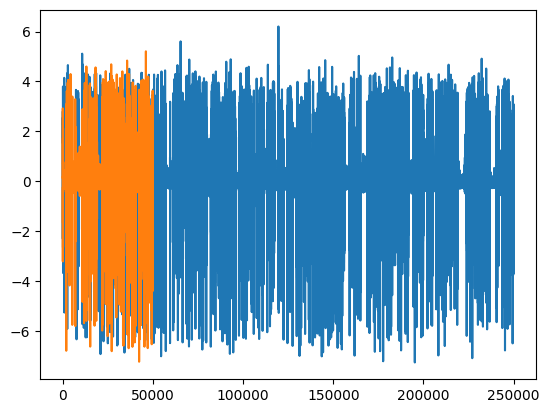

In [31]:
# Init pack

import numpy as np
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt

psi = np.load('/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy')

psi = psi[:,1,:]

# Normalization
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi
# Pre-processing

lead = 1

trainN = 250000
valN = 50000
index = 63

variable_range = [(0,24), (25, 49), (50, 74)]

# Select the variable: 0 for real perturbation, 1 for imaginary perturbation, 2 for zonal winds
variable = 0


print(psi.shape)

np_psi_train_input = psi[0:trainN, variable_range[variable][0]:variable_range[variable][1]+1]
plt.plot(np_psi_train_input[:, -1])

np_psi_train_label = psi[lead:trainN+lead, :]

psi_train_input = torch.tensor(np_psi_train_input)
psi_train_label =  torch.tensor(np_psi_train_label)

# Make sure input and label lengths match
assert psi_train_input.shape[0] == psi_train_label.shape[0], "Input and label length mismatch"

#shuffle and map indices\
valid_indices = np.arange(0, trainN - lead)
np.random.seed(42)  # Optional for reproducibility
shuffled_indices = np.random.permutation(valid_indices)

np_psi_train_input = psi[shuffled_indices, variable_range[variable][0]:variable_range[variable][1]+1]
np_psi_train_label = psi[shuffled_indices + lead, :]

psi_train_input = torch.tensor(np_psi_train_input)
psi_train_label = torch.tensor(np_psi_train_label)

t = shuffled_indices[0]
print(torch.allclose(psi_train_input[0], torch.tensor(psi[t, variable_range[variable][0]:variable_range[variable][1]+1])))
print(torch.allclose(psi_train_label[0], torch.tensor(psi[t + 1])))

np_psi_val_input = psi[trainN:trainN+valN, variable_range[variable][0]:variable_range[variable][1]+1]
np_psi_val_label = psi[trainN+lead:trainN+valN+lead, :]
psi_val_input = torch.tensor(np_psi_val_input)
psi_val_label =  torch.tensor(np_psi_val_label)

print(psi_train_input.shape)
print(psi_train_label.shape)
print(psi_val_input.shape)
print(psi_val_label.shape)
plt.plot(np_psi_val_input[:,-1])
plt.show()
# plt.plot(psi_val_input[0:50000,63])

In [32]:
# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        # self.fc1 = nn.Linear(75, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        # self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        # self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        # self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        # self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        # self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        # self.fc_mu = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Latent space (2)
        # self.fc_logvar = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Log variance (2)

    def forward(self, x):
        # x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        # x = torch.relu(self.fc2(x)) + x
        # x = torch.relu(self.fc3(x)) + x
        # x = torch.relu(self.fc4(x)) + x
        # x = torch.relu(self.fc5(x)) + x
        # # x = torch.relu(self.fc6(x)) + x
        # mu = self.fc_mu(x)
        # logvar = self.fc_logvar(x)
        return None

# Define the decoder (MLP)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_output = nn.Linear(512, output_dim)  # Hidden layer (128) -> Output layer (2)

    def forward(self, z, condition):
        z = torch.cat((z, condition), dim=1)  # Concatenate latent vector and condition
        z = torch.relu(self.fc1(z))  # Activation function for hidden layer
        z = torch.relu(self.fc2(z)) + z
        z = torch.relu(self.fc3(z)) + z
        z = torch.relu(self.fc4(z)) + z
        z = torch.relu(self.fc5(z)) + z
        z = torch.relu(self.fc6(z)) + z
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim)

    def decode(self, z, condition):
        return self.decoder(z, condition)

    def forward(self, z, condition,):
        z = torch.randn(z.size(0), z.size(1)).to(z.device)  # Sample from standard normal distribution
        output = self.decode(z, condition)
        return output

output_dim = 75
latent_dim = 1024
condition_dim = 25
batch_size = 1024
num_epochs = 100

In [ ]:
# Training

import datetime
import os
from scipy.stats import linregress

def normalize_transition_time(slope_value, delta, transition_real):
    normalized = 1 - np.exp(-np.abs((slope_value - transition_real)) / delta)
    return normalized

def total_variation_distance(p, q):
    p = np.array(p)
    q = np.array(q)
    return 0.5 * np.sum(np.abs(p - q))

def calculate_transition_durations(y_values, upper_bound, lower_bound):
    times_between_transitions = []
    transition_start = None
    above_upper = False
    below_lower = False
    for i in range(1, len(y_values)):
        if y_values[i] < lower_bound:
            below_lower = True
            above_upper = False
        elif y_values[i] > upper_bound:
            if below_lower and transition_start is not None:
                times_between_transitions.append(i - transition_start)
                transition_start = None
            above_upper = True
            below_lower = False
        if below_lower and transition_start is None:
            transition_start = i
    return times_between_transitions

latent_dims = [144]
latent_dim = 144
kl_coefficients = [10]
num_cycles = 10
upper_bound = 53.8 / 2.8935
lower_bound = 7.41
level = 63

best_distance = float('inf')
tvd_list = []
transition_list = []
transition_list_unormalized = []

real_data = np.load(r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy")
real_data_1d = real_data[:, 1, level]
real_durations = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)
real_data_sorted = np.sort(real_durations)
transition_real = np.mean(real_data_sorted)
actual_hist, bin_edges = np.histogram(real_data[:, 1, level], bins=50, density=True)
print(f"Reference Real Data average_transition_time: {transition_real}")

tvds_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}
transitions_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}
transitions_normalized_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}
exp_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}

lat_folder = f"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_{datetime.datetime.now()}"
os.makedirs(lat_folder)

for kl_coef in kl_coefficients:
    print(f"USING KL COEF OF {kl_coef}")
    best_models = []
    best_models_saved = []
    for cycle in range(0,num_cycles):
        tvd_cycle_list = []
        transition_cycle_list = []
        transition_cycle_list_unormalized = []
        
        # Initialize the model, optimizer, and loss function
        model = ConditionalVAE(latent_dim, output_dim, condition_dim)
        model = model.cuda()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        num_epochs = 10

        folder = f"{lat_folder}/model_at_{cycle}_with_kl_{kl_coef}"
        os.makedirs(folder)
        subfolders = ['timeseries', 'expo_fit', '2D', 'summary']

        # Create each subdirectory inside the main folder
        for subfolder in subfolders:
            path = os.path.join(folder, subfolder)
            os.mkdir(path)
            print(f"Created subfolder: {path}")

        # from torchsummary import summary

        # summary(model, input_size = [(128, 1, 75), (128, 75)])
        # Train the model
        for epoch in range(num_epochs):
            z_train = torch.zeros([batch_size,latent_dim])
            z_val = torch.zeros([batch_size,latent_dim])
            model.train()
            for batch in range (0, trainN, batch_size):
                
                # end = min(batch + batch_size, trainN)
                # indices = np.random.permutation(np.arange(start=batch, step=1,stop=end))
                # input_batch, label_batch = psi_train_input[indices], psi_train_label[indices]
                input_batch = psi_train_input[batch:batch + batch_size,:]
                label_batch = psi_train_label[batch:batch + batch_size,:]

                optimizer.zero_grad()

                z_train = torch.randn_like(z_train)
                z_train = z_train[:input_batch.shape[0],:]

                output = model(z_train.float().cuda(), input_batch.float().cuda())

                # Reconstruction loss
                reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
                
                # Total loss
                loss = reconstruction_loss

                loss.backward()
                optimizer.step()

            print(f'''Epoch {epoch+1}, 
                Reconstrunction Loss: {loss.item()}''')

            # Validation Loss
            for batch in range (0, valN, batch_size):

                # end = min(batch + batch_size, valN)
                # indices = np.random.permutation(np.arange(start=batch, step=1,stop=end))
                # input_batch, label_batch = psi_val_input[indices], psi_val_label[indices]
                input_batch = psi_val_input[batch:batch + batch_size,:]
                label_batch = psi_val_label[batch:batch + batch_size,:]
                
                z_val = torch.randn_like(z_val)
                z_val = z_val[:input_batch.shape[0],:]

                output = model(z_val.float().cuda(), input_batch.float().cuda())

                # Reconstruction loss
                val_reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
                
                # Total loss
                val_loss = val_reconstruction_loss
                # Print both reconstruction_loss and kl_loss

            print(f'''
                Validation Reconstrunction Loss: {val_loss.item()}''')
            
            # Inference

            initial_cond = torch.reshape(torch.tensor(psi[0,:]), [1, 75])
            time_step = 30000
            z = torch.zeros([1,latent_dim])
            num_ens = 1
            pred = np.zeros ([time_step, 75, num_ens])

            for k in range (0, time_step):

                for ens in range (0, num_ens):
                    if (k ==0):
                        z = torch.randn_like(z)
                        print(z.shape, initial_cond.shape)
                        y = (model.decode(z.float().cuda(),initial_cond.float().cuda())).detach().cpu().numpy()
                        pred[k,:,ens] = y
                        y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                        initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

                    else:
                        select_ens = np.random.randint(0,num_ens,1)
                        z = torch.randn_like(z)
                        y = (model.decode(z.float().cuda(),torch.reshape(torch.tensor(pred[k-1,:,select_ens]),[1,75]).float().cuda())).detach().cpu().numpy()
                        pred[k,:, ens] = y
                        y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                        initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

            # Denormalize final preds
            print(std_psi[:, 63])
            pred_mean = pred * std_psi[:, 63] + mean_psi[:, 63]

            # Denormalize test labels
            actual_values = psi_train_label[:time_step, 63] * std_psi[:, 63] + mean_psi[:, 63]
            print(actual_values)
            
            real_data_1d = real_data[:30000, 0, 63]  # Now shape is (309700,)
            predictions_1d = pred_mean[:, 63]  # shape (300000,)

            plt.figure(figsize=(20,8))
            plt.plot(pred_mean[0:30000,63],'r')
            plt.plot(real_data[0:30000, 0, 63])
            plt.grid(True)
            plt.title(f"Predictions vs Actual | Epoch {epoch}")
            save_path = os.path.join(folder, "timeseries")
            save_path = os.path.join(save_path, f"timeseries_plot_{epoch}.png")
            plt.savefig(save_path)
            plt.xlabel('Time Step')
            plt.ylabel('Zonal Wind Value')
            plt.legend(['Predictions', 'Actual'])
            plt.tight_layout()
            plt.show()
            
            # Function to calculate transition durations
            def calculate_transition_durations(y_values, upper_bound, lower_bound):
                times_between_transitions = []
                transition_start = None
                above_upper = False
                below_lower = False

                for i in range(1, len(y_values)):
                    if y_values[i] < lower_bound:  
                        below_lower = True
                        above_upper = False
                    elif y_values[i] > upper_bound:  
                        if below_lower and transition_start is not None:
                            times_between_transitions.append(i - transition_start)
                            transition_start = None  
                        above_upper = True
                        below_lower = False

                    if below_lower and transition_start is None:
                        transition_start = i

                return times_between_transitions
            
            predictions_1d = pred_mean[:, level, 0]
            pred_durations = calculate_transition_durations(predictions_1d, upper_bound, lower_bound)
            print(pred_durations)
            pred_hist, _ = np.histogram(predictions_1d, bins=bin_edges, density=True)

            # === PREDICTIONS CCDF AND FIT ===
            exponential_fit_pred = 0

            # if len(pred_durations) > 0:
            transition_pred = np.mean(pred_durations)
            transition_cycle_list.append(normalize_transition_time(transition_pred, 1000, transition_real))
            transition_cycle_list_unormalized.append(transition_pred)
            transitions_by_dim_cycle[kl_coef][cycle].append(transition_pred)
            transitions_normalized_by_dim_cycle[kl_coef][cycle].append(normalize_transition_time(transition_pred, 1000, transition_real))

            tvd = total_variation_distance(pred_hist, actual_hist)
            tvd_cycle_list.append(tvd)
            tvds_by_dim_cycle[kl_coef][cycle].append(tvd)

            distance = np.sqrt(tvd ** 2 + (normalize_transition_time(transition_pred, 1000, transition_real)) ** 2)

            print(f"Epoch {epoch+1}: TVD = {tvd:.6f}, Transition_Difference = {transition_pred-transition_real:.6f}, Combined Distance = {distance:.6f}")
            torch.save(model.state_dict(), f"{folder}/model_at_epoch{epoch}")

            if distance < best_distance:
                best_distance = distance
                torch.save(model.state_dict(), f"{folder}/best_model_combined_distance.pth")
                print("New best model saved based on TVD + transition difference distance.")
            # else:
            #     print("No transitions detected in predictions.")
            #     transitions_by_dim_cycle[kl_coef][cycle].append(np.nan)
            #     tvds_by_dim_cycle[kl_coef][cycle].append(np.nan)
            #     tvd_cycle_list.append(np.nan)
            #     transition_cycle_list.append(np.nan)
            #     transition_cycle_list_unormalized.append(np.nan)


            # Plot labels and formatting

            x_line_real = np.linspace(min(real_data_sorted), max(real_data_sorted), 100)
            exponential_fit_real = 1/np.mean(real_data_sorted)
            y_values_real = exponential_fit_real*x_line_real
            plt.plot(x_line_real, y_values_real, 'b-', label=f'Real Exp Fit (slope={exponential_fit_real:.4f})', linewidth=2)

            if len(pred_durations) > 0:
                x_line_pred = np.linspace(min(pred_durations), max(pred_durations), 100)
                exponential_fit_pred = 1/np.mean(pred_durations)
                y_values_pred = exponential_fit_pred*x_line_pred
                plt.plot(x_line_pred, y_values_pred, 'r-', label=f'Pred Exp Fit (slope={exponential_fit_pred:.4f})', linewidth=2)
                exp_by_dim_cycle[kl_coef][cycle].append(exponential_fit_pred)

            plt.xlabel('Time Duration (Steps)')
            plt.ylabel('Exponential Fit')
            plt.title('Exponential Fit of Time Between B->A and A->B Transitions (Exponential Fit)')
            plt.yscale("linear")  # y-axis log scale
            plt.xscale("linear")  # x-axis linear scale
            plt.grid()
            plt.legend()
            plt.tight_layout()
            save_path = os.path.join(folder, "expo_fit")
            save_path = os.path.join(save_path, f"expo_fit_plot_{epoch}.png")
            plt.savefig(save_path)
            plt.show()

            plt.figure(figsize=(12, 6))
            plt.plot(tvd, transition_pred, 'o-', label=f'Cycle {cycle}')
            plt.xlabel("Total Variation Distance")
            plt.ylabel("Average Transition Time")
            plt.axhline(y=transition_real, color='r', linestyle='--', label='Real Data')
            plt.ylim(0.1,2000)
            plt.xlim(0, 1)
            plt.title("TVD vs. Avg Transition Time per Epoch")
            plt.grid(True)
            save_path = os.path.join(folder, "2D")
            save_path = os.path.join(save_path, f"2D_plot_{epoch}.png")
            plt.savefig(save_path)
            plt.show()
            
            if epoch == num_epochs - 1:  # Last epoch of last cycle for this dimension
                # Plot TVDs with cycles overlapped
                plt.figure(figsize=(10, 6))
                for c in range(num_cycles):
                    plt.plot(tvds_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                
                plt.xlabel('Epoch within Cycle')
                plt.ylabel('Total Variation Distance')
                plt.title(f'TVD Progress (KL Coefficient={kl_coef})')
                plt.grid(True)
                plt.legend()
                save_path = os.path.join(folder, "summary")
                save_path = os.path.join(save_path, f"tvd_plot_all_cycles.png")
                plt.savefig(save_path)
                plt.show()
                
                # Plot Exponential Fits with cycles overlapped
                plt.figure(figsize=(10, 6))
                for c in range(num_cycles):
                    plt.plot(transitions_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                
                plt.axhline(y=transition_real, color='r', linestyle='--', label='Real Data')
                plt.xlabel('Epoch within Cycle')
                plt.ylabel('Average Transition Value')
                plt.ylim(0.1,2000)
                plt.title(f'Average Transition Progress (KL Coefficient={kl_coef})')
                plt.grid(True)
                plt.legend()
                save_path = os.path.join(folder, "summary")
                save_path = os.path.join(save_path, f"transition_plot_all_cycles.png")
                plt.savefig(save_path)
                plt.show()

                plt.figure(figsize=(10, 6))
                for c in range(num_cycles):
                    plt.plot(exp_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                
                plt.axhline(y=exponential_fit_real, color='r', linestyle='--', label='Real Data')
                plt.xlabel('Epoch within Cycle')
                plt.ylabel('Exponential Fit Value')
                plt.title(f'Exponential Fit Progress (KL Coefficient={kl_coef})')
                plt.grid(True)
                plt.legend()
                save_path = os.path.join(folder, "summary")
                save_path = os.path.join(save_path, f"exponential_fit_plot_all_cycles.png")
                plt.savefig(save_path)
                plt.show()
                
                # Plot TVD and 1/average transition time per epoch
                plt.figure(figsize=(12, 6))
                plt.scatter(tvd_cycle_list, transition_cycle_list, c=range(len(tvd_cycle_list)), cmap='viridis')
                plt.colorbar(label='Epoch')
                plt.xlabel("Total Variation Distance")
                plt.ylabel("Average Transition Time")
                plt.title("TVD vs. Avg Transition Time per Epoch")
                plt.grid(True)
                save_path = os.path.join(folder, "summary")
                save_path = os.path.join(save_path, f"tvd_vs_transition_plot_all_cycles.png")
                plt.savefig(save_path)
                plt.show()
                
                # If this is the last latent dimension, create master graphs with all dimensions
                if kl_coef == kl_coefficients[-1] and cycle == num_cycles - 1:
                    # Create a master folder for overlapping graphs
                        
                        # Plot TVDs with cycles overlapped
                    plt.figure(figsize=(10, 6))
                    for c in range(num_cycles):
                        plt.plot(tvds_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                    
                    plt.xlabel('Epoch within Cycle')
                    plt.ylabel('Total Variation Distance')
                    plt.title(f'TVD Progress (KL Coefficient={kl_coef})')
                    plt.grid(True)
                    plt.legend()
                    save_path = os.path.join(lat_folder, f"tvd_plot_all_cycles.png")
                    plt.savefig(save_path)
                    plt.show()
                    
                    # Plot Exponential Fits with cycles overlapped
                    plt.figure(figsize=(10, 6))
                    for c in range(num_cycles):
                        plt.plot(transitions_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                    
                    plt.axhline(y=transition_real, color='r', linestyle='--', label='Real Data')
                    plt.xlabel('Epoch within Cycle')
                    plt.ylabel('Average Transition Value')
                    plt.ylim(0.1,2000)
                    plt.title(f'Average Transition Progress (KL Coefficient={kl_coef})')
                    plt.grid(True)
                    plt.legend()
                    save_path = os.path.join(lat_folder, f"transition_plot_all_cycles.png")
                    plt.savefig(save_path)
                    plt.show()

                    plt.figure(figsize=(10, 6))
                    for c in range(num_cycles):
                        plt.plot(exp_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                    
                    plt.axhline(y=exponential_fit_real, color='r', linestyle='--', label='Real Data')
                    plt.xlabel('Epoch within Cycle')
                    plt.ylabel('Exponential Fit Value')
                    plt.title(f'Exponential Fit Progress (KL Coefficient={kl_coef})')
                    plt.grid(True)
                    plt.legend()
                    save_path = os.path.join(lat_folder, f"exponential_fit_plot_all_cycles.png")
                    plt.savefig(save_path)
                    plt.show()
                    
                    # Plot TVD and 1/average transition time per epoch
                    plt.figure(figsize=(12, 6))
                    plt.scatter(tvd_cycle_list, transition_cycle_list, c=range(len(tvd_cycle_list)), cmap='viridis')
                    plt.colorbar(label='Epoch')
                    plt.xlabel("Total Variation Distance")
                    plt.ylabel("Average Transition Time")
                    plt.title("TVD vs. Avg Transition Time per Epoch")
                    plt.grid(True)
                    save_path = os.path.join(lat_folder, f"tvd_vs_transition_plot_all_cycles.png")
                    plt.savefig(save_path)
                    plt.show()

            torch.save(model.state_dict(), f"{folder}/checkpoint_{epoch+1}")
            print(f"Model weights saved to {folder} with point {epoch+1}.")
        
            tvd_list.append(tvd_cycle_list)
            transition_list.append(transition_cycle_list)
            transition_list_unormalized.append(transition_cycle_list_unormalized)

        # Save the model after each cycle
        index = -1
        best_distance = float('inf')
        for i in range(0, num_cycles):
            distance = np.sqrt(tvds_by_dim_cycle[kl_coef][cycle][i] ** 2 + transitions_normalized_by_dim_cycle[kl_coef][cycle][i] ** 2)
            if distance < best_distance:
                best_distance = distance
                torch.save(model.state_dict(), f"{folder}/best_model_combined_distance.pth")
                print("New best model saved based on TVD + normalized average transition value.")
                index = i
                best_models_saved.append(model.state_dict())
        best_models.append(index)


    best_model_distance = float('inf')
    for i,n in enumerate(best_models):
        distance = np.sqrt(tvds_by_dim_cycle[kl_coef][i][n] ** 2 + transitions_normalized_by_dim_cycle[kl_coef][i][n] ** 2)
        if distance < best_model_distance:
            best_model_distance = distance
            best_model = best_models_saved[i]
            where_model = (i,n)
    # Save the best model  
    coordinates = where_model
    cycle = i
    epoch = n
    torch.save(best_model, f"{lat_folder}/best_model_combined_distance.pth")
    print(f"Best model saved based on TVD + normalized average transition value with cycle {i+1} and epoch {n+1}.")

# CHOOSING BY EXP FIT

Reference Real Data average_transition_time: 759.8341708542714
Reference Real Data CCDF Slope: -0.001349964964925677
USING KL COEF OF 10
Created subfolder: /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 16:53:16.140293/model_at_0_with_kl_10/timeseries
Created subfolder: /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 16:53:16.140293/model_at_0_with_kl_10/expo_fit
Created subfolder: /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 16:53:16.140293/model_at_0_with_kl_10/2D
Created subfolder: /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 16:53:16.140293/model_at_0_with_kl_10/summary
Epoch 1, 
                Reconstrunction Loss: 

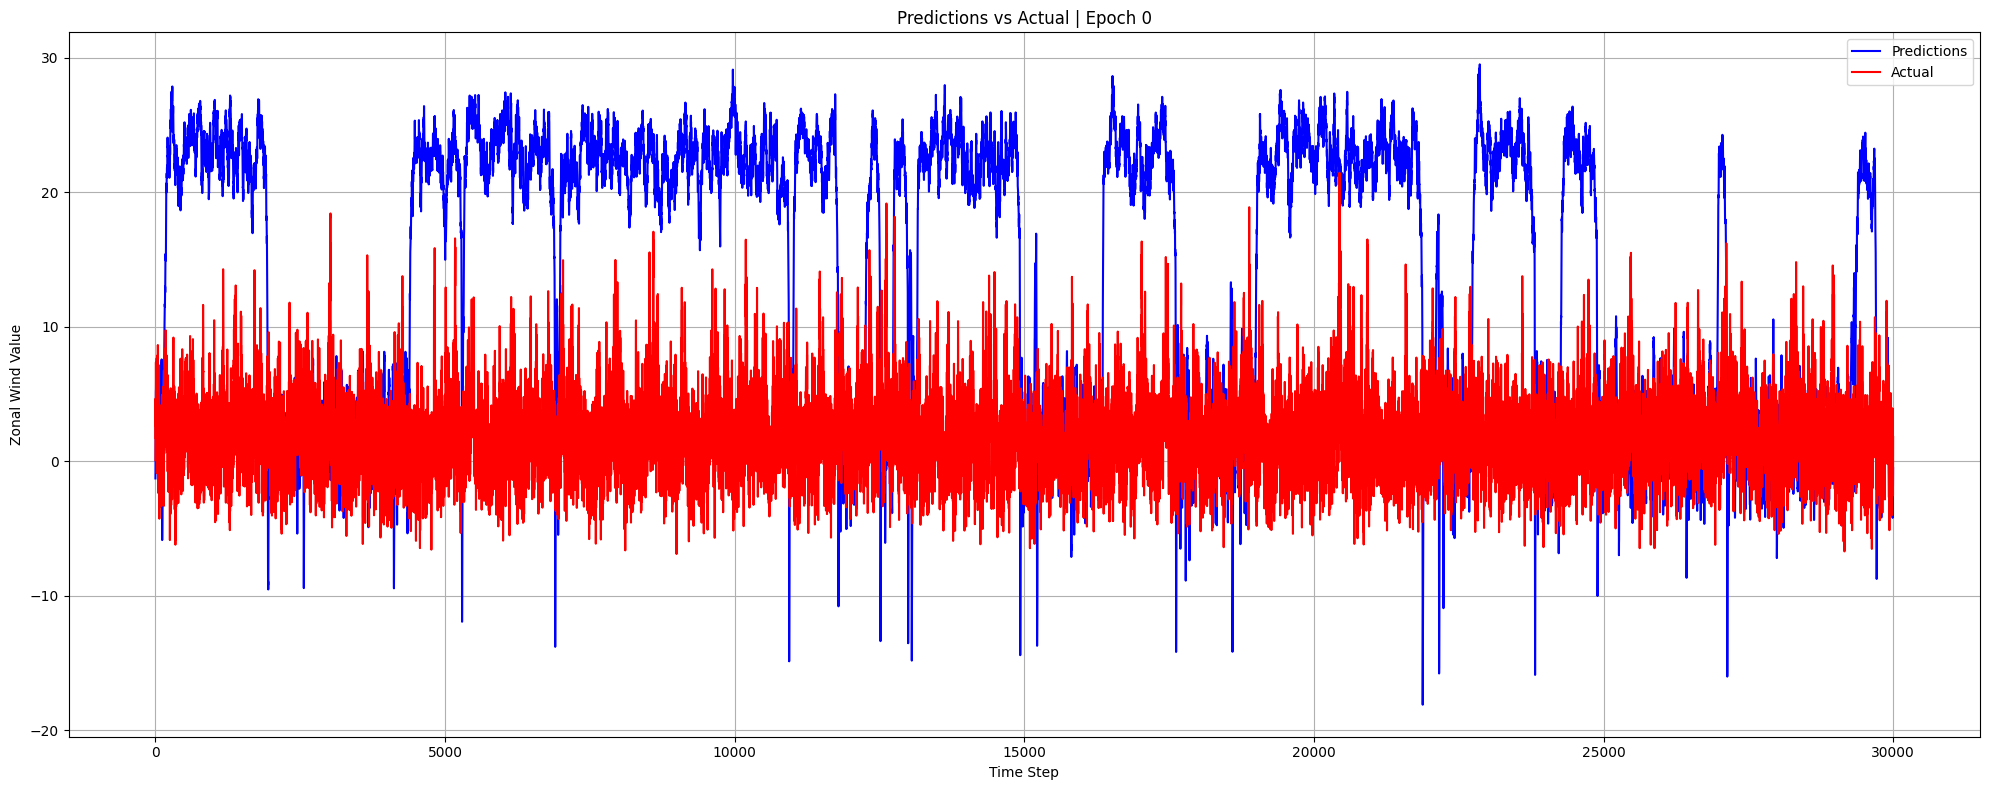

[12619, 6256, 1547]
Slope difference at epoch 1: 0.001202
12619 1547
11072


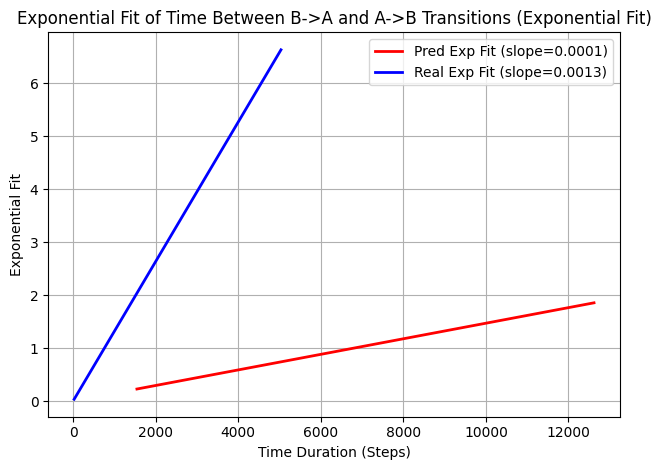

Duration Difference: 0.454580
Exponential Fit: 0.000147


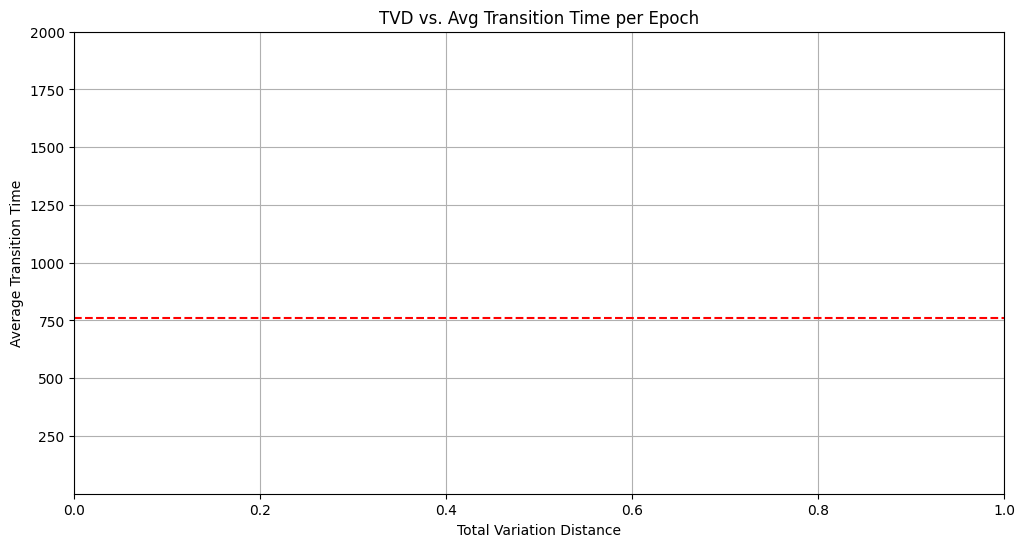

Epoch 1: Slope Difference Normalized = 0.001202, Transition Difference Normalized = 0.994946, Duration Difference Normalized = 0.454580, Combined Distance = 1.093875
Model weights saved to /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 16:53:16.140293/model_at_0_with_kl_10 with point 1.
Epoch 2, 
                Reconstrunction Loss: 3144.2314453125

                Validation Reconstrunction Loss: 31846.39453125
torch.Size([1, 25])
torch.Size([1, 1024]) torch.Size([1, 25])
[10.68167255]
[[2.01167838 1.98370626 1.71642692 ... 0.47837973 0.41047157 0.35863518]
 [1.55372345 1.48781631 1.25849655 ... 1.2734918  1.25983925 1.23271053]
 [1.1969409  1.06317644 0.83593358 ... 1.86287243 1.79900517 1.73394638]
 ...
 [3.05132583 2.42403951 1.82987497 ... 2.85119504 3.00369765 3.04415186]
 [1.77777737 1.28050779 0.91390213 ... 2.72175555 2.8178898  2.82288918]
 [0.54944567 0.25870675 0.18215527 ... 2.9013

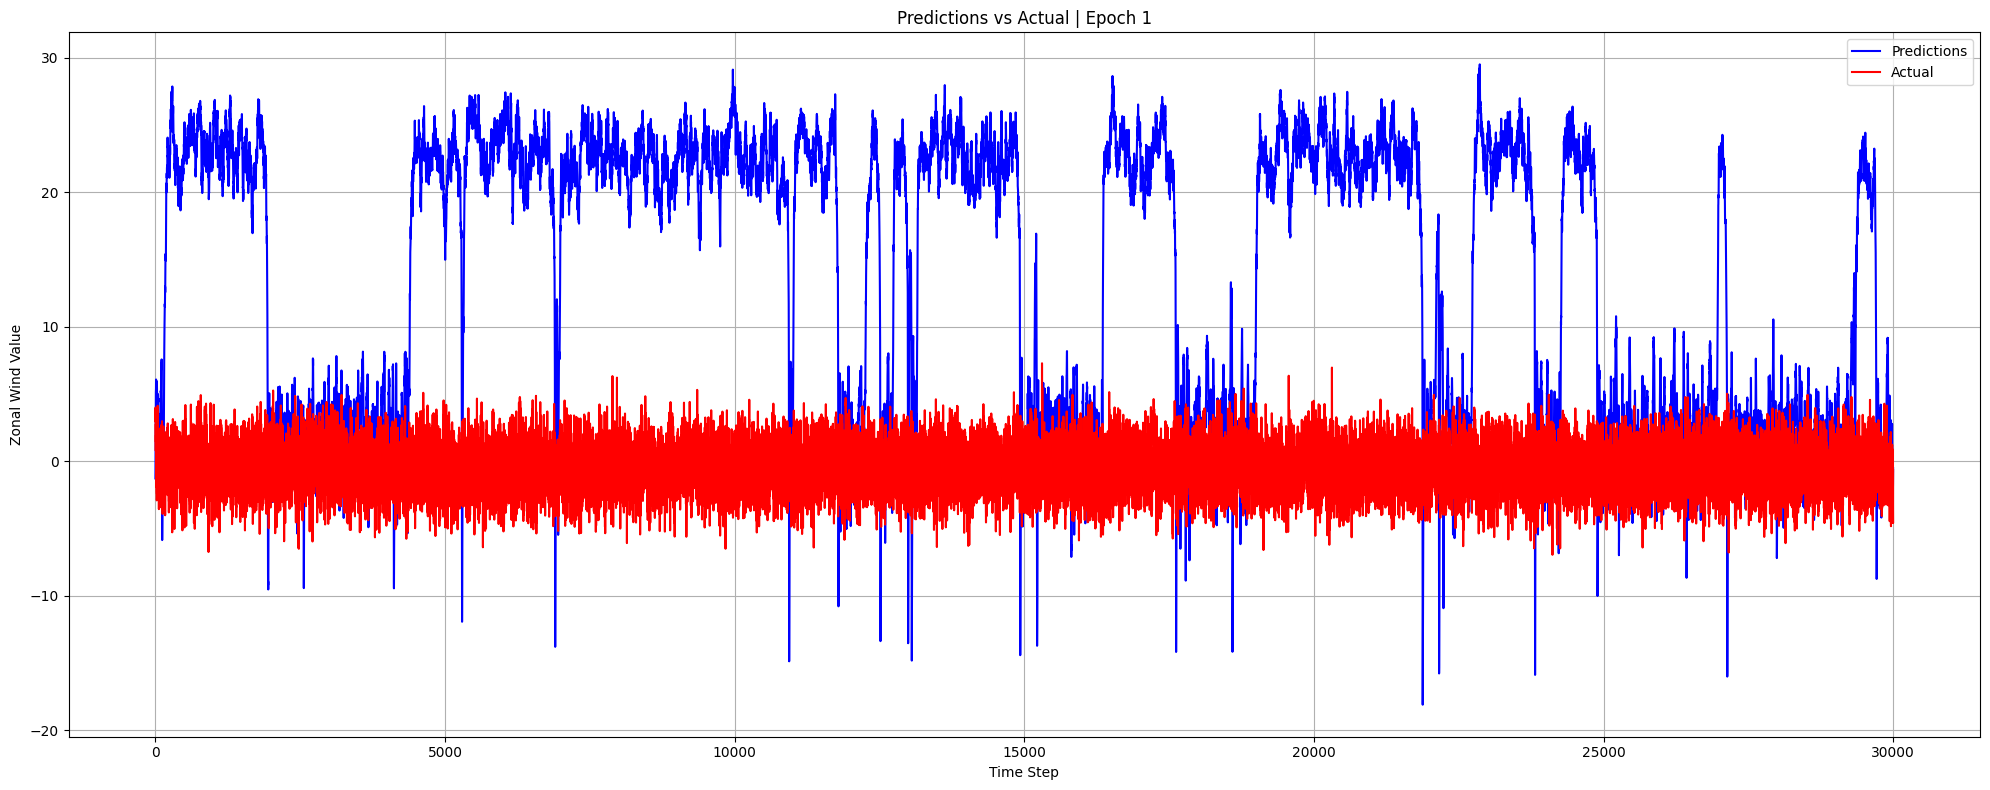

[]
No transitions detected in predictions for CCDF slope evaluation.


/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


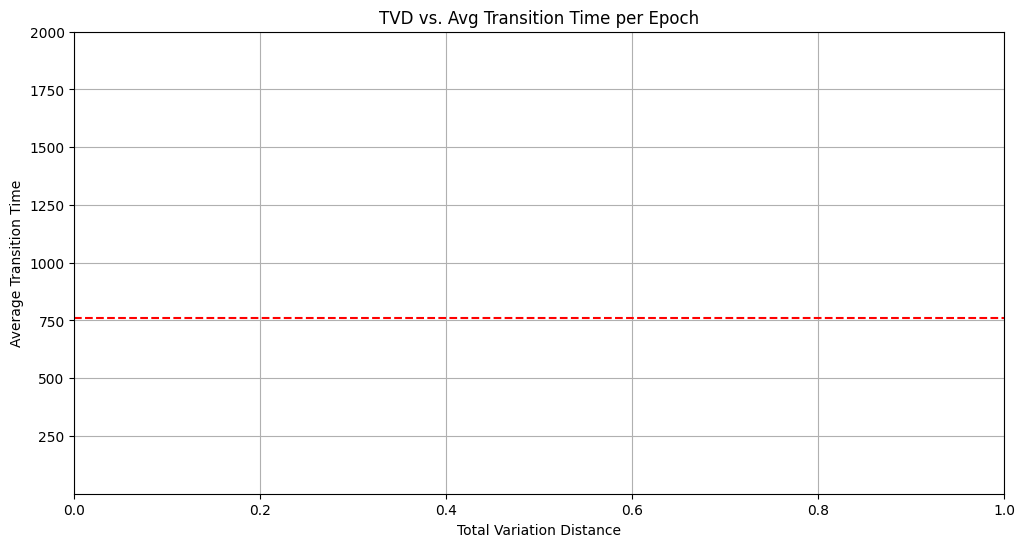

Epoch 2: Slope Difference Normalized = 1.000000, Transition Difference Normalized = nan, Duration Difference Normalized = 1.000000, Combined Distance = nan
Model weights saved to /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 16:53:16.140293/model_at_0_with_kl_10 with point 2.
Epoch 3, 
                Reconstrunction Loss: 2953.415771484375

                Validation Reconstrunction Loss: 29398.2734375
torch.Size([1, 25])
torch.Size([1, 1024]) torch.Size([1, 25])
[10.68167255]
[[2.01167838 1.98370626 1.71642692 ... 0.47837973 0.41047157 0.35863518]
 [1.55372345 1.48781631 1.25849655 ... 1.2734918  1.25983925 1.23271053]
 [1.1969409  1.06317644 0.83593358 ... 1.86287243 1.79900517 1.73394638]
 ...
 [3.05132583 2.42403951 1.82987497 ... 2.85119504 3.00369765 3.04415186]
 [1.77777737 1.28050779 0.91390213 ... 2.72175555 2.8178898  2.82288918]
 [0.54944567 0.25870675 0.18215527 ... 2.90131854 2.97

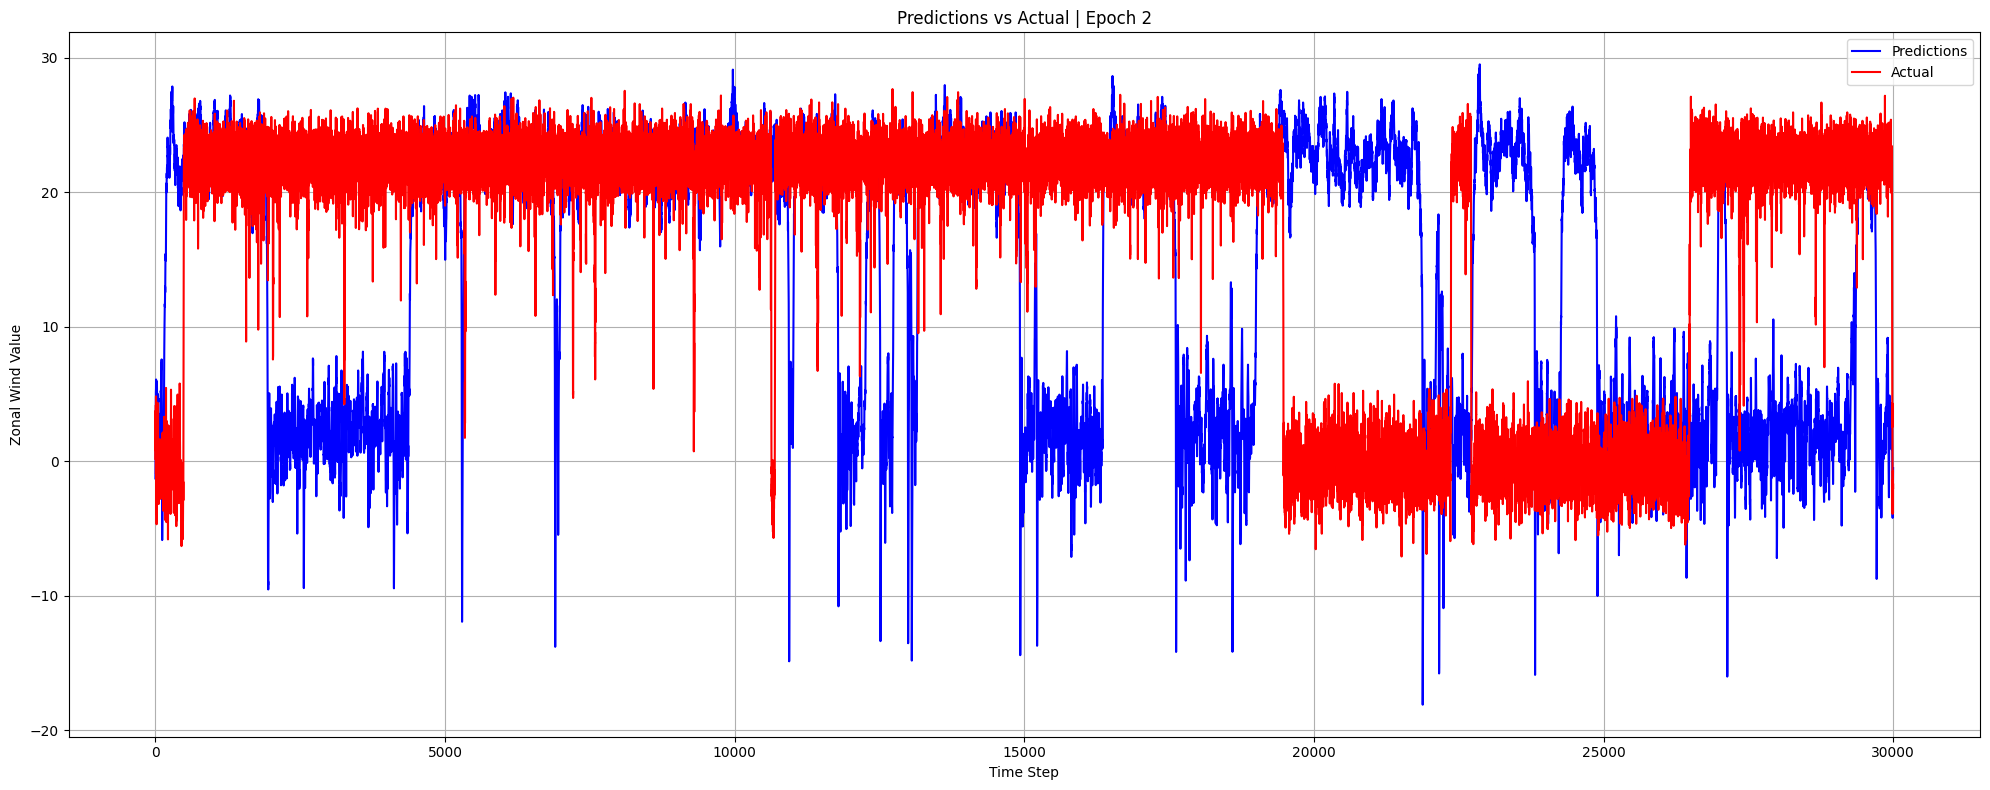

[488, 11, 16, 10, 7, 6, 19, 69, 11, 5, 2, 2894, 3778, 16, 10, 2]
Slope difference at epoch 3: 0.000579
3778 2
3776


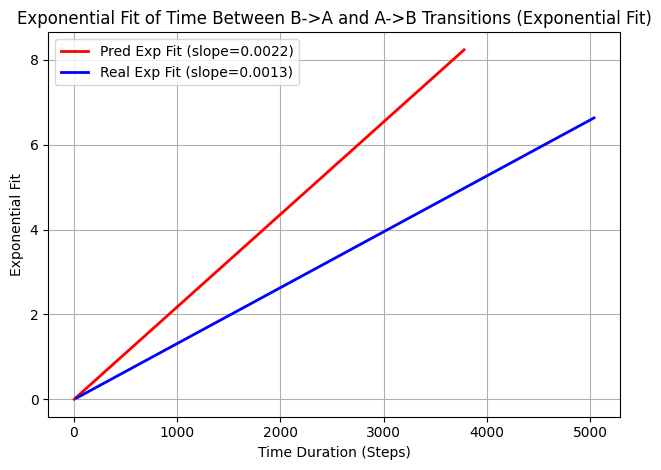

Duration Difference: 0.116090
Exponential Fit: 0.002179


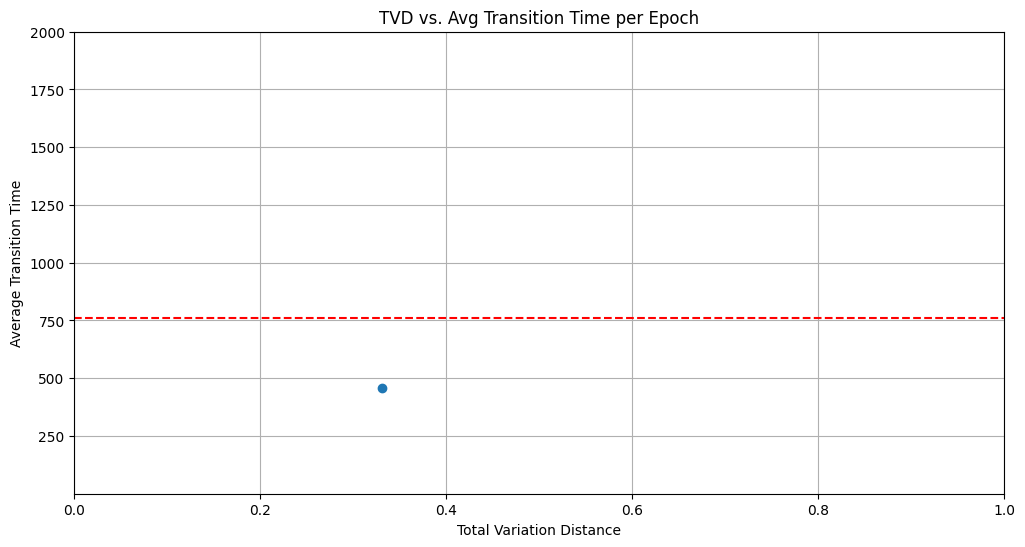

Epoch 3: Slope Difference Normalized = 0.000579, Transition Difference Normalized = 0.368085, Duration Difference Normalized = 0.116090, Combined Distance = 0.385958
Model weights saved to /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 16:53:16.140293/model_at_0_with_kl_10 with point 3.
Epoch 4, 
                Reconstrunction Loss: 2677.691650390625

                Validation Reconstrunction Loss: 28322.609375
torch.Size([1, 25])
torch.Size([1, 1024]) torch.Size([1, 25])
[10.68167255]
[[2.01167838 1.98370626 1.71642692 ... 0.47837973 0.41047157 0.35863518]
 [1.55372345 1.48781631 1.25849655 ... 1.2734918  1.25983925 1.23271053]
 [1.1969409  1.06317644 0.83593358 ... 1.86287243 1.79900517 1.73394638]
 ...
 [3.05132583 2.42403951 1.82987497 ... 2.85119504 3.00369765 3.04415186]
 [1.77777737 1.28050779 0.91390213 ... 2.72175555 2.8178898  2.82288918]
 [0.54944567 0.25870675 0.18215527 ... 2.9013

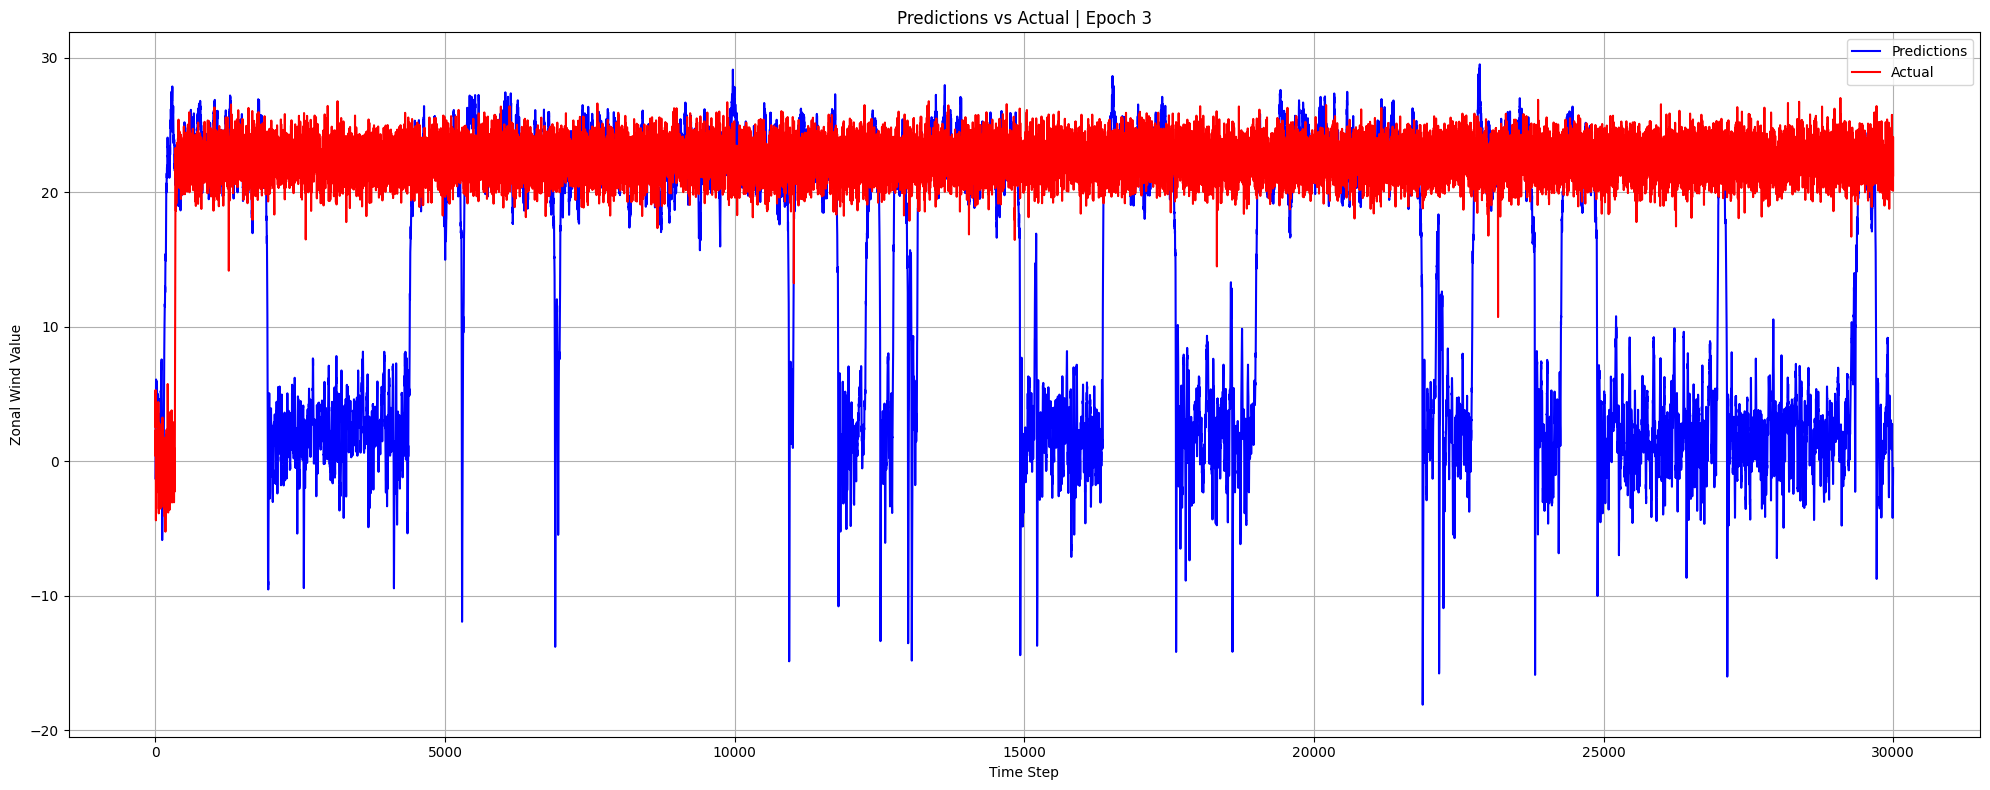

[343]
No transitions detected in predictions for CCDF slope evaluation.


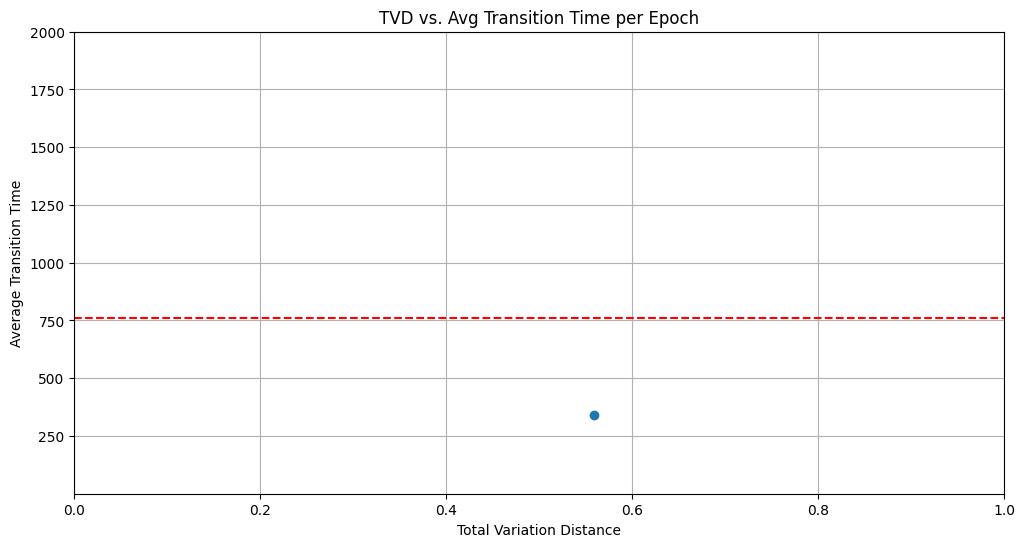

Epoch 4: Slope Difference Normalized = 1.000000, Transition Difference Normalized = 0.290362, Duration Difference Normalized = 1.000000, Combined Distance = 1.041302
Model weights saved to /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 16:53:16.140293/model_at_0_with_kl_10 with point 4.
Epoch 5, 
                Reconstrunction Loss: 2454.6181640625

                Validation Reconstrunction Loss: 27661.0703125
torch.Size([1, 25])
torch.Size([1, 1024]) torch.Size([1, 25])
[10.68167255]
[[2.01167838 1.98370626 1.71642692 ... 0.47837973 0.41047157 0.35863518]
 [1.55372345 1.48781631 1.25849655 ... 1.2734918  1.25983925 1.23271053]
 [1.1969409  1.06317644 0.83593358 ... 1.86287243 1.79900517 1.73394638]
 ...
 [3.05132583 2.42403951 1.82987497 ... 2.85119504 3.00369765 3.04415186]
 [1.77777737 1.28050779 0.91390213 ... 2.72175555 2.8178898  2.82288918]
 [0.54944567 0.25870675 0.18215527 ... 2.90131

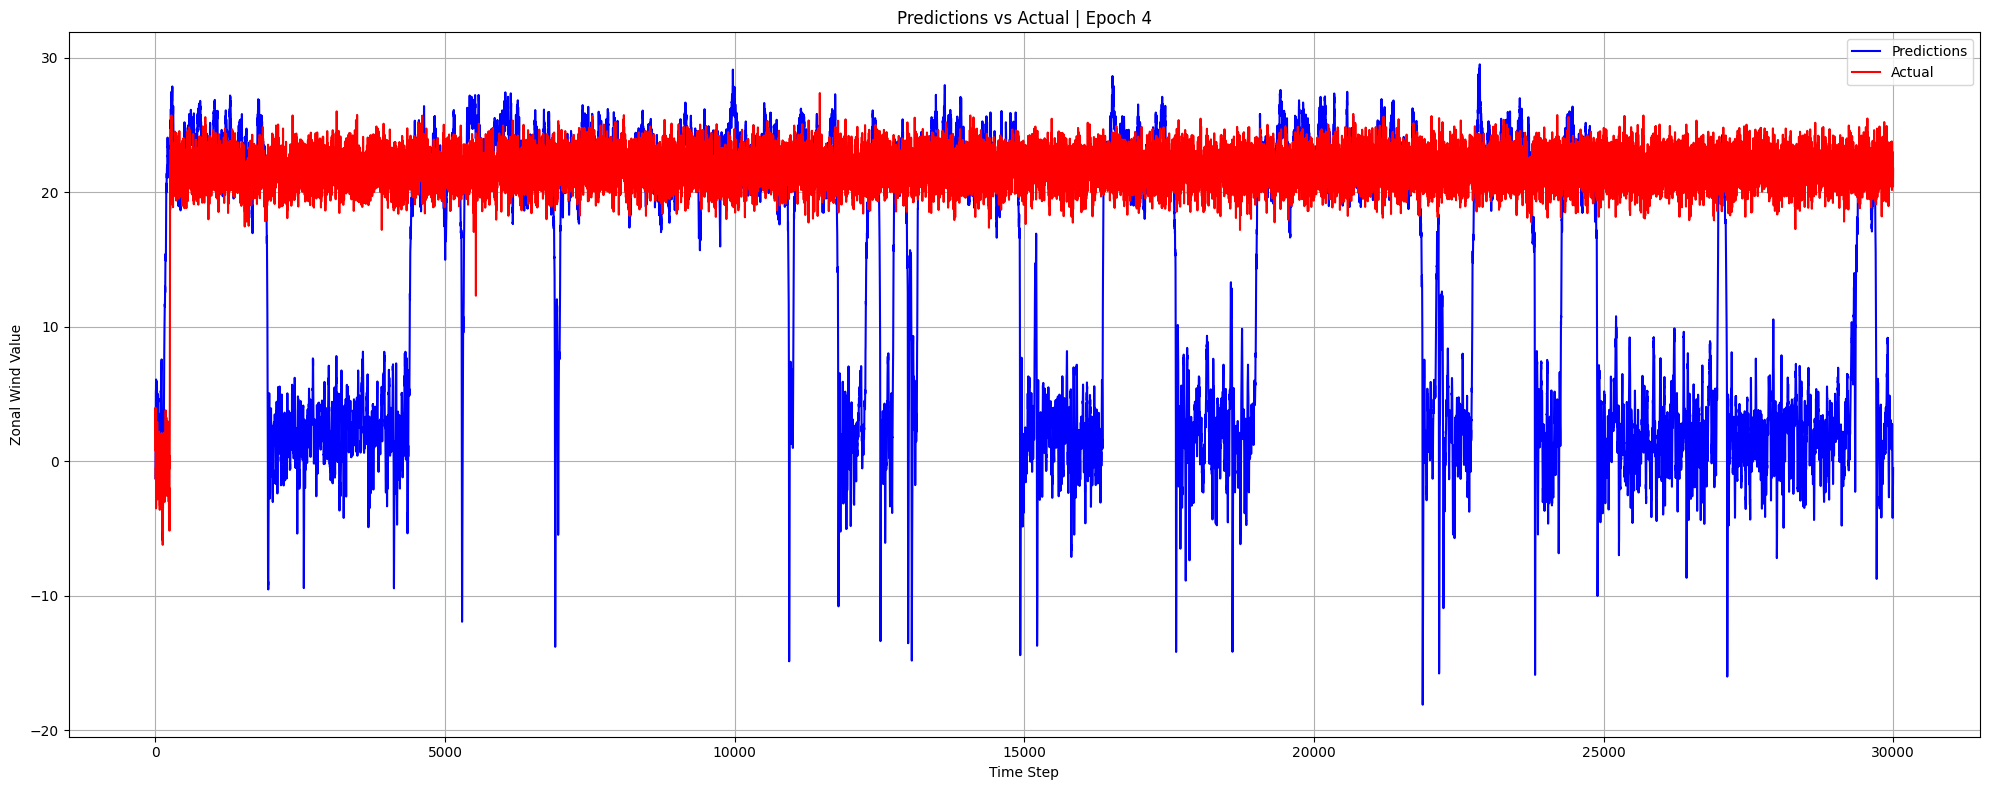

[252]
No transitions detected in predictions for CCDF slope evaluation.


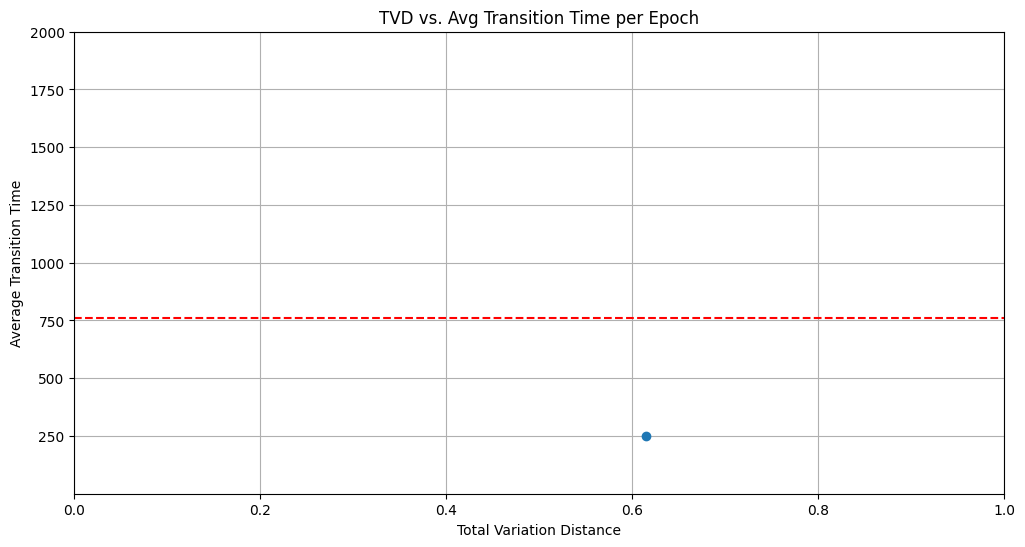

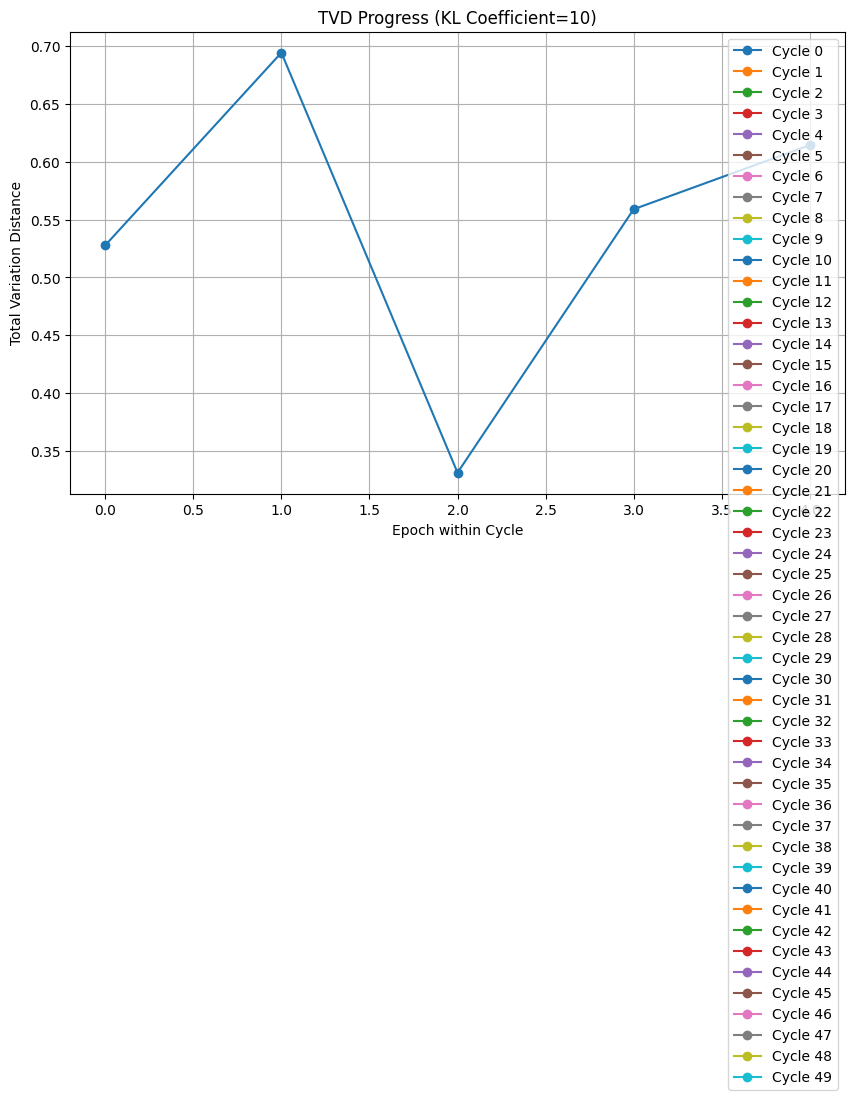

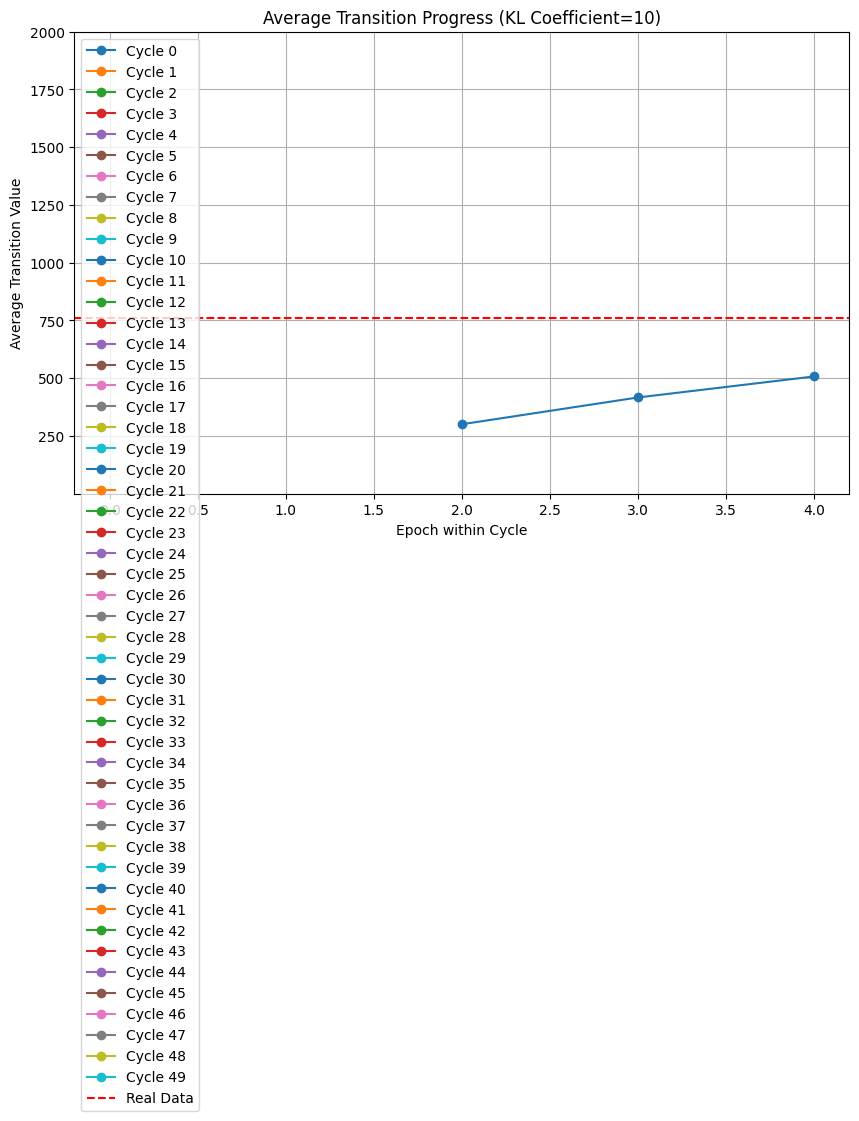

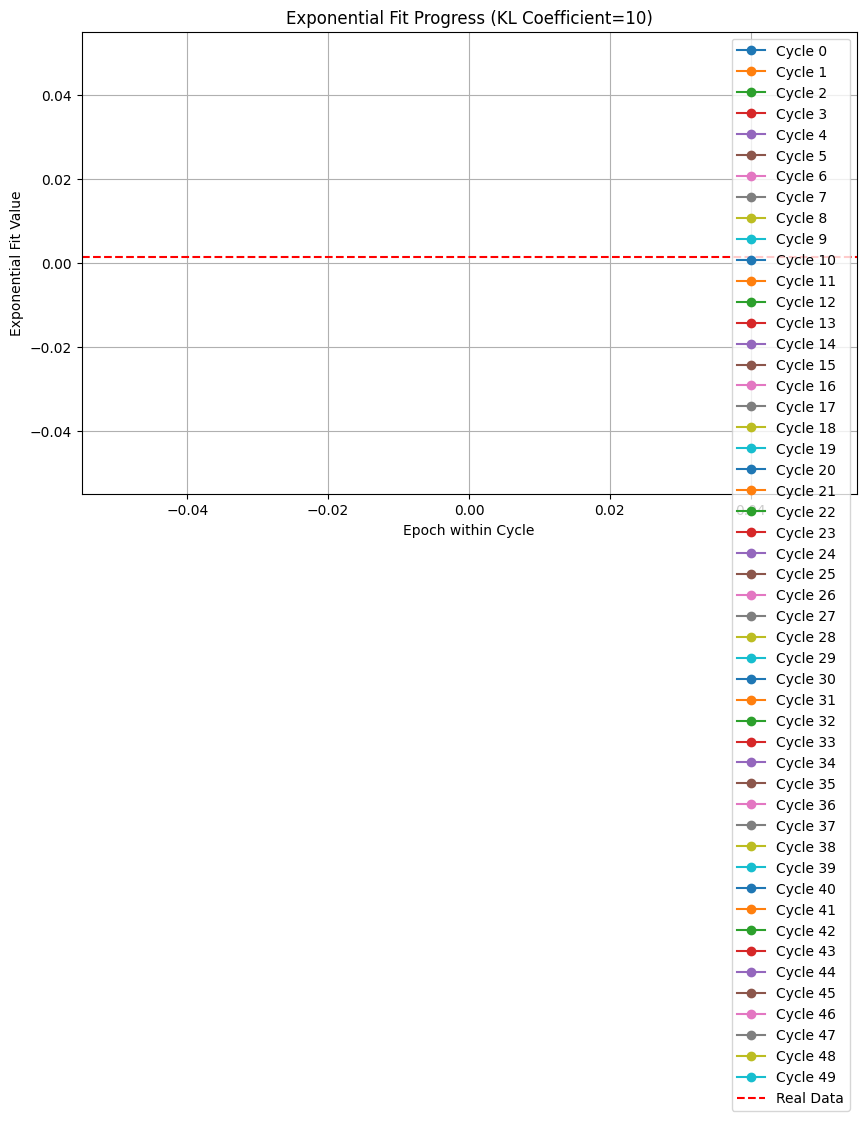

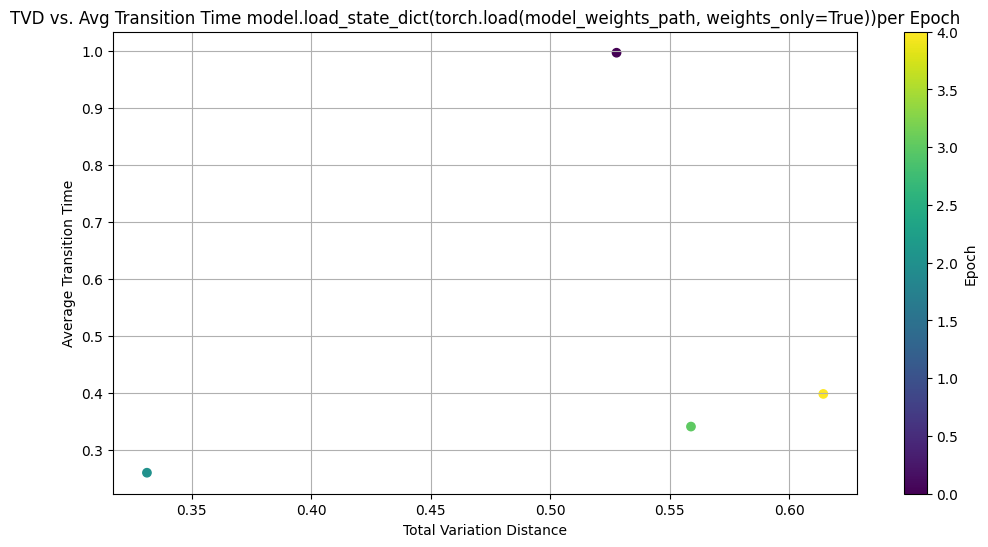

Epoch 5: Slope Difference Normalized = 1.000000, Transition Difference Normalized = 0.222755, Duration Difference Normalized = 1.000000, Combined Distance = 1.024510
Model weights saved to /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 16:53:16.140293/model_at_0_with_kl_10 with point 5.
0.0012020456702079851
1
0.0005786422502045419
1
1
New best model saved with distance 1.0939 at epoch 1
New best model saved with distance 0.3860 at epoch 3
Created subfolder: /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 16:53:16.140293/model_at_1_with_kl_10/timeseries
Created subfolder: /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 16:53:16.140293/model_at_1_with_kl_10/expo_fit
Created subfolder: /home/constantino-daniel-boscu/Do

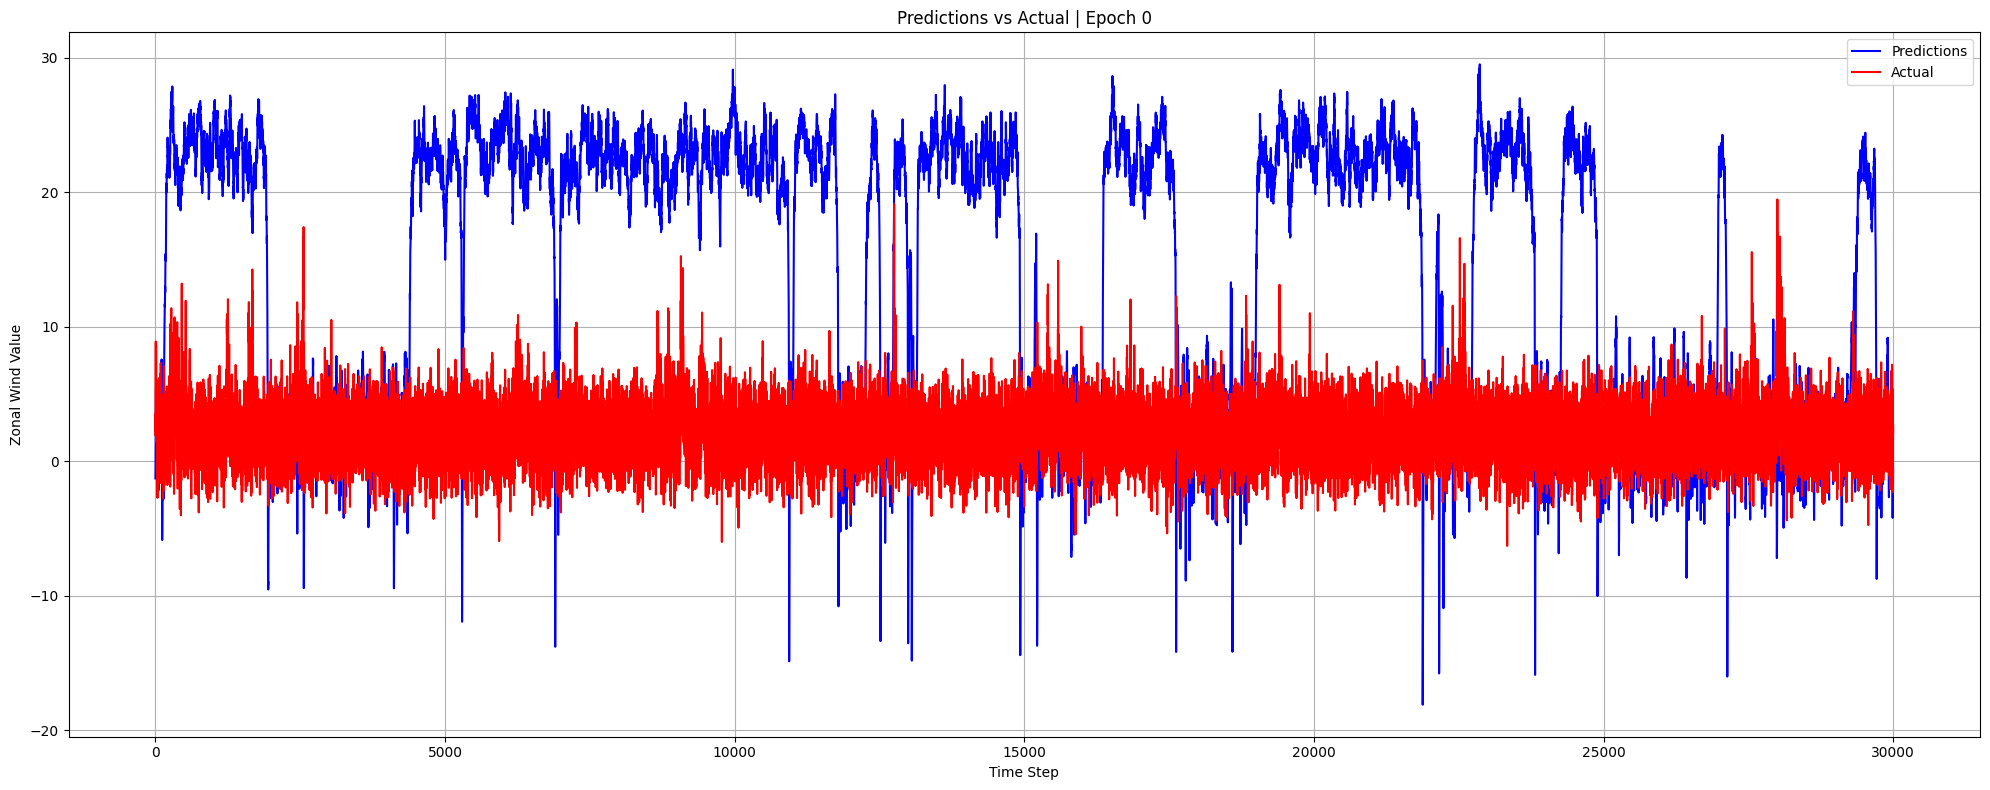

[12752, 15240]
Slope difference at epoch 1: nan
15240 12752
2488


/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10729: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10743: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10749: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


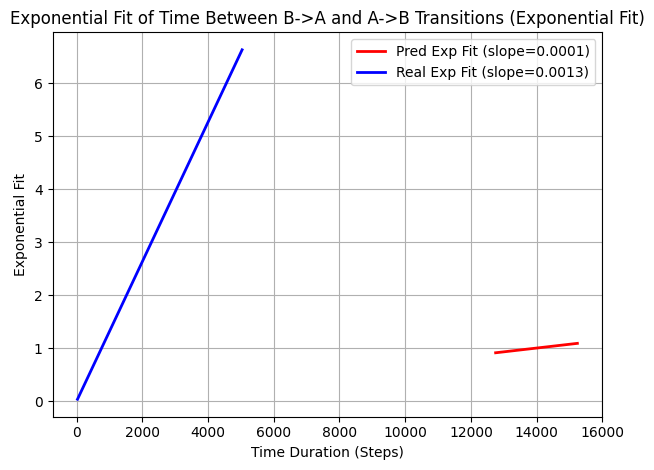

Duration Difference: 0.222911
Exponential Fit: 0.000071


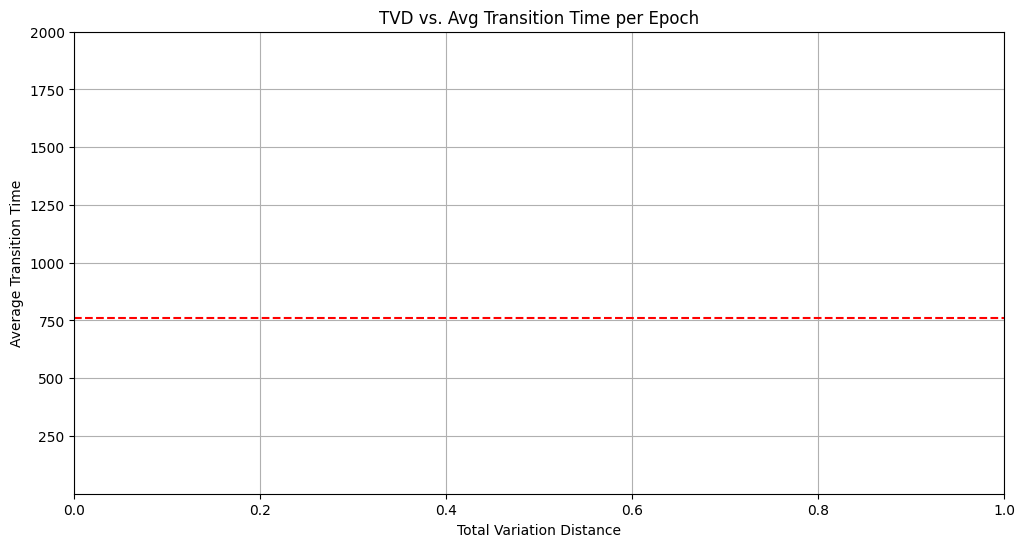

Epoch 1: Slope Difference Normalized = nan, Transition Difference Normalized = 0.999996, Duration Difference Normalized = 0.222911, Combined Distance = 1.024540
Model weights saved to /home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 16:53:16.140293/model_at_1_with_kl_10 with point 1.
Epoch 2, 
                Reconstrunction Loss: 3099.8828125

                Validation Reconstrunction Loss: 31552.40625
torch.Size([1, 25])
torch.Size([1, 1024]) torch.Size([1, 25])


KeyboardInterrupt: 

In [37]:
# Training

import datetime
import os
import shutil
from scipy.stats import linregress

def normalize_transition_time(slope_value, delta, transition_real):
    normalized = 1 - np.exp(-np.abs((slope_value - transition_real)) / delta)
    return normalized

def total_variation_distance(p, q):
    p = np.array(p)
    q = np.array(q)
    return 0.5 * np.sum(np.abs(p - q))

def calculate_transition_durations(y_values, upper_bound, lower_bound):
    times_between_transitions = []
    transition_start = None
    above_upper = False
    below_lower = False
    for i in range(1, len(y_values)):
        if y_values[i] < lower_bound:
            below_lower = True
            above_upper = False
        elif y_values[i] > upper_bound:
            if below_lower and transition_start is not None:
                times_between_transitions.append(i - transition_start)
                transition_start = None
            above_upper = True
            below_lower = False
        if below_lower and transition_start is None:
            transition_start = i
    return times_between_transitions

latent_dims = [1024]
latent_dim = 1024
kl_coefficients = [10]
num_cycles = 50
upper_bound = 53.8 / 2.8935
lower_bound = 7.41
level = 63

TRAIN_N = 250000
VAL_N = 50000
best_distance = float('inf')

real_data = np.load(r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy")
real_data_1d = real_data[:, 1, level]

# Function to calculate transition durations
real_durations = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)
real_data_sorted = np.sort(real_durations)
transition_real = np.mean(real_data_sorted)

actual_hist, bin_edges = np.histogram(real_data[:, 1, level], bins=50, density=True)
print(f"Reference Real Data average_transition_time: {transition_real}")

# Compute CCDF slope for real data
ccdf_real = 1 - np.arange(1, len(real_data_sorted) + 1) / len(real_data_sorted)

valid_indices_real = ccdf_real > 0
x_fit_real = real_data_sorted[valid_indices_real]
y_fit_real = np.log(ccdf_real[valid_indices_real])

slope_real, intercept_real, *_ = linregress(x_fit_real, y_fit_real)
print(f"Reference Real Data CCDF Slope: {slope_real}")

tvds_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}
transitions_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}
transitions_normalized_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}
exp_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}
duration_diff_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}
slope_diff_by_dim_cycle = {kl: {cycle: [] for cycle in range(num_cycles)} for kl in kl_coefficients}

models_by_dim_cycle = []

lat_folder = f"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_{datetime.datetime.now()}"

os.makedirs(lat_folder)

for kl_coef in kl_coefficients:
    print(f"USING KL COEF OF {kl_coef}")

    best_models = []
    best_models_saved = []

    tvd_list = []
    transition_list = []
    transition_list_unormalized = []
    exp_list = []
    duration_diff_list = []
    slope_diff_list = []

    for cycle in range(0,num_cycles):

        models = []

        tvd_cycle_list = []
        transition_cycle_list = []
        transition_cycle_list_unormalized = []
        exp_cycle_list = []
        duration_diff_cycle_list = []
        slope_diff_cycle_list = []
        
        # Initialize the model, optimizer, and loss function
        model = ConditionalVAE(latent_dim, output_dim, condition_dim)
        model = model.cuda()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        num_epochs = 5

        folder = f"{lat_folder}/model_at_{cycle}_with_kl_{kl_coef}"
        os.makedirs(folder)
        subfolders = ['timeseries', 'expo_fit', '2D', 'summary']

        # Create each subdirectory inside the main folder
        for subfolder in subfolders:
            path = os.path.join(folder, subfolder)
            os.mkdir(path)
            print(f"Created subfolder: {path}")

        for epoch in range(num_epochs):

            z_train = torch.zeros([batch_size,latent_dim])
            z_val = torch.zeros([batch_size,latent_dim])
            model.train()
            for batch in range (0, TRAIN_N, batch_size):
                
                # end = min(batch + batch_size, trainN)
                # indices = np.random.permutation(np.arange(start=batch, step=1,stop=end))
                # input_batch, label_batch = psi_train_input[indices], psi_train_label[indices]
                input_batch = psi_train_input[batch:batch + batch_size,:]
                label_batch = psi_train_label[batch:batch + batch_size,:]

                optimizer.zero_grad()

                z_train = torch.randn_like(z_train)
                z_train = z_train[:input_batch.shape[0],:]

                output = model(z_train.float().cuda(), input_batch.float().cuda())

                # Reconstruction loss
                reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
                
                # Total loss
                loss = reconstruction_loss

                loss.backward()
                optimizer.step()

            print(f'''Epoch {epoch+1}, 
                Reconstrunction Loss: {loss.item()}''')

            # Validation Loss
            for batch in range (0, VAL_N, batch_size):

                # end = min(batch + batch_size, valN)
                # indices = np.random.permutation(np.arange(start=batch, step=1,stop=end))
                # input_batch, label_batch = psi_val_input[indices], psi_val_label[indices]
                input_batch = psi_val_input[batch:batch + batch_size,:]
                label_batch = psi_val_label[batch:batch + batch_size,:]
                
                z_val = torch.randn_like(z_val)
                z_val = z_val[:input_batch.shape[0],:]

                output = model(z_val.float().cuda(), input_batch.float().cuda())

                # Reconstruction loss
                val_reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
                
                # Total loss
                val_loss = val_reconstruction_loss
                # Print both reconstruction_loss and kl_loss

            print(f'''
                Validation Reconstrunction Loss: {val_loss.item()}''')
            
            # Inference

            start, end = variable_range[variable][0], variable_range[variable][1]+1
            initial_cond = torch.reshape(torch.tensor(psi[0,start:end]), [1, 25])
            print(initial_cond.shape)
            time_step = 30000
            z = torch.zeros([1,latent_dim])
            num_ens = 1
            pred = np.zeros ([time_step, 75, num_ens])

            for k in range (0, time_step):

                for ens in range (0, num_ens):
                    if (k ==0):
                        z = torch.randn_like(z)
                        print(z.shape, initial_cond.shape)
                        y = (model.decode(z.float().cuda(),initial_cond.float().cuda())).detach().cpu().numpy()
                        pred[k,:,ens] = y
                        y_denorm_contracted = (y[:, start:end] * std_psi[:, start:end] + mean_psi[:, start:end])
                        initial_cond = torch.tensor((y_denorm_contracted[:, start:end] - mean_psi[:, start:end]) / std_psi[:, start:end])

                    else:
                        select_ens = np.random.randint(0,num_ens,1)
                        z = torch.randn_like(z)
                        y = (model.decode(z.float().cuda(),torch.reshape(torch.tensor(pred[k-1,start:end,select_ens]),[1,25]).float().cuda())).detach().cpu().numpy()
                        pred[k,:, ens] = y
                        y_denorm_contracted = (y[:, start:end] * std_psi[:, start:end] + mean_psi[:, start:end])
                        initial_cond = torch.tensor((y_denorm_contracted[:, start:end] - mean_psi[:, start:end]) / std_psi[:, start:end])

            
            # Denormalize final preds
            print(std_psi[:, 63])
            pred_mean = pred[:time_step, :] * std_psi[:, 63] + mean_psi[:, 63]

            # Denormalize test labels
            actual_values = psi[trainN:trainN+time_step, :] * std_psi[:, 63] + mean_psi[:, 63]
            print(actual_values)
            
            real_data_1d = actual_values[:30000, 63]  # Now shape is (309700,)
            predictions_1d = pred_mean[:, 63]  # shape (300000,)
            print(predictions_1d.shape, real_data_1d.shape)

            plt.figure(figsize=(20,8))
            plt.plot(actual_values[0:30000, 63], 'b')
            plt.plot(pred_mean[0:30000, 63],'r')
            plt.grid(True)
            plt.title(f"Predictions vs Actual | Epoch {epoch}")
            save_path = os.path.join(folder, "timeseries")
            save_path = os.path.join(save_path, f"timeseries_plot_{epoch}.png")
            plt.savefig(save_path)
            plt.xlabel('Time Step')
            plt.ylabel('Zonal Wind Value')
            plt.legend(['Predictions', 'Actual'])
            plt.tight_layout()
            plt.show()
            
            # Function to calculate transition durations
            def calculate_transition_durations(y_values, upper_bound, lower_bound):
                times_between_transitions = []
                transition_start = None
                above_upper = False
                below_lower = False

                for i in range(1, len(y_values)):
                    if y_values[i] < lower_bound:  
                        below_lower = True
                        above_upper = False
                    elif y_values[i] > upper_bound:  
                        if below_lower and transition_start is not None:
                            times_between_transitions.append(i - transition_start)
                            transition_start = None  
                        above_upper = True
                        below_lower = False

                    if below_lower and transition_start is None:
                        transition_start = i

                return times_between_transitions
            
            predictions_1d = pred_mean[:, level, 0]
            pred_durations = calculate_transition_durations(predictions_1d, upper_bound, lower_bound)
            print(pred_durations)
            pred_hist, _ = np.histogram(predictions_1d, bins=bin_edges, density=True)

            # if len(pred_durations) > 0:
            transition_pred = np.mean(pred_durations)
            transition_diff = abs(transition_pred - transition_real)
            transition_cycle_list.append(normalize_transition_time(transition_pred, 1000, transition_real))
            transition_cycle_list_unormalized.append(transition_pred)
            transitions_by_dim_cycle[kl_coef][cycle].append(transition_diff)
            transition_diff_normalized = normalize_transition_time(transition_diff, 1000, transition_real)
            transitions_normalized_by_dim_cycle[kl_coef][cycle].append(transition_diff_normalized)

            tvd = total_variation_distance(pred_hist, actual_hist)
            tvd_cycle_list.append(tvd)
            tvds_by_dim_cycle[kl_coef][cycle].append(tvd)

            # === PREDICTIONS CCDF AND FIT ===
            slope_diff_normalized = 1

            if len(pred_durations) > 0 and len(np.unique(pred_durations)) > 1:
                pred_data_sorted = np.sort(pred_durations)
                ccdf_pred = 1 - np.arange(1, len(pred_data_sorted) + 1) / len(pred_data_sorted)

                valid_indices_pred = ccdf_pred > 0
                x_fit_pred = pred_data_sorted[valid_indices_pred]
                y_fit_pred = np.log(ccdf_pred[valid_indices_pred])

                slope_pred, intercept_pred, *_ = linregress(x_fit_pred, y_fit_pred)
                slope_diff_normalized = normalize_transition_time(slope_pred, 1, slope_real)
                slope_diff_cycle_list.append(slope_diff_normalized)

                print(f"Slope difference at epoch {epoch+1}: {slope_diff_normalized:.6f}")

            else:
                print("No transitions detected in predictions for CCDF slope evaluation.")

            exponential_fit_pred = 0
            duration_diff_normalized = 1

            # Plot labels and formatting
            x_line_real = np.linspace(min(real_data_sorted), max(real_data_sorted), 100)
            exponential_fit_real = 1/np.mean(real_data_sorted)
            y_values_real = exponential_fit_real*x_line_real

            if len(pred_durations) > 0 and  len(np.unique(pred_durations)) > 1:

                x_line_pred = np.linspace(min(pred_durations), max(pred_durations), 100)
                exponential_fit_pred = 1/np.mean(pred_durations)
                y_values_pred = exponential_fit_pred*x_line_pred

                max_pred = np.max(pred_durations)
                min_pred = np.min(pred_durations)
                print(max_pred, min_pred)
                
                if max_pred > 0:

                    difference = abs(max_pred - min_pred)
                    print(difference)
                    duration_diff_normalized = normalize_transition_time(difference, 10000, abs(np.max(real_durations)-np.min(real_durations)))
                    exp_cycle_list.append(exponential_fit_pred)
                    duration_diff_cycle_list.append(duration_diff_normalized)

                    plt.plot(x_line_pred, y_values_pred, 'r-', label=f'Pred Exp Fit (slope={exponential_fit_pred:.4f})', linewidth=2)
                    plt.plot(x_line_real, y_values_real, 'b-', label=f'Real Exp Fit (slope={exponential_fit_real:.4f})', linewidth=2)
                    plt.xlabel('Time Duration (Steps)')
                    plt.ylabel('Exponential Fit')
                    plt.title('Exponential Fit of Time Between B->A and A->B Transitions (Exponential Fit)')
                    plt.yscale("linear")  # y-axis log scale
                    plt.xscale("linear")  # x-axis linear scale
                    plt.grid()
                    plt.legend()
                    plt.tight_layout()
                    save_path = os.path.join(folder, "expo_fit")
                    save_path = os.path.join(save_path, f"expo_fit_plot_{epoch}.png")
                    plt.savefig(save_path)
                    plt.show()
                    print(f"Duration Difference: {duration_diff_normalized:.6f}")
                    print(f"Exponential Fit: {exponential_fit_pred:.6f}")
                else:
                    exp_cycle_list.append(exponential_fit_pred)
                    duration_diff_cycle_list.append(duration_diff_normalized)
                    print("No distribution of transitions detected in predictions.")

            duration_diff_by_dim_cycle[kl_coef][cycle].append(duration_diff_normalized)
            slope_diff_by_dim_cycle[kl_coef][cycle].append(slope_diff_normalized)

            plt.figure(figsize=(12, 6))
            plt.plot(tvd, transition_pred, 'o-', label=f'Cycle {cycle}')
            plt.xlabel("Total Variation Distance")
            plt.ylabel("Average Transition Time")
            plt.axhline(y=transition_real, color='r', linestyle='--', label='Real Data')
            plt.ylim(0.1,2000)
            plt.xlim(0, 1)
            plt.title("TVD vs. Avg Transition Time per Epoch")
            plt.grid(True)
            save_path = os.path.join(folder, "2D")
            save_path = os.path.join(save_path, f"2D_plot_{epoch}.png")
            plt.savefig(save_path)
            plt.show()
            
            if epoch == num_epochs - 1:  # Last epoch of last cycle for this dimension
                # Plot TVDs with cycles overlapped
                plt.figure(figsize=(10, 6))
                for c in range(num_cycles):
                    plt.plot(tvds_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                
                plt.xlabel('Epoch within Cycle')
                plt.ylabel('Total Variation Distance')
                plt.title(f'TVD Progress (KL Coefficient={kl_coef})')
                plt.grid(True)
                plt.legend()
                save_path = os.path.join(folder, "summary")
                save_path = os.path.join(save_path, f"tvd_plot_all_cycles.png")
                plt.savefig(save_path)
                plt.show()
                
                # Plot Exponential Fits with cycles overlapped
                plt.figure(figsize=(10, 6))
                for c in range(num_cycles):
                    plt.plot(transitions_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                
                plt.axhline(y=transition_real, color='r', linestyle='--', label='Real Data')
                plt.xlabel('Epoch within Cycle')
                plt.ylabel('Average Transition Value')
                plt.ylim(0.1,2000)
                plt.title(f'Average Transition Progress (KL Coefficient={kl_coef})')
                plt.grid(True)
                plt.legend()
                save_path = os.path.join(folder, "summary")
                save_path = os.path.join(save_path, f"transition_plot_all_cycles.png")
                plt.savefig(save_path)
                plt.show()

                plt.figure(figsize=(10, 6))
                for c in range(num_cycles):
                    plt.plot(exp_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                
                plt.axhline(y=exponential_fit_real, color='r', linestyle='--', label='Real Data')
                plt.xlabel('Epoch within Cycle')
                plt.ylabel('Exponential Fit Value')
                plt.title(f'Exponential Fit Progress (KL Coefficient={kl_coef})')
                plt.grid(True)
                plt.legend()
                save_path = os.path.join(folder, "summary")
                save_path = os.path.join(save_path, f"exponential_fit_plot_all_cycles.png")
                plt.savefig(save_path)
                plt.show()
                
                # Plot TVD and 1/average transition time per epoch
                plt.figure(figsize=(12, 6))
                plt.scatter(tvd_cycle_list, transition_cycle_list, c=range(len(tvd_cycle_list)), cmap='viridis')
                plt.colorbar(label='Epoch')
                plt.xlabel("Total Variation Distance")
                plt.ylabel("Average Transition Time")
                plt.title("TVD vs. Avg Transition Time model.load_state_dict(torch.load(model_weights_path, weights_only=True))per Epoch")
                plt.grid(True)
                save_path = os.path.join(folder, "summary")
                save_path = os.path.join(save_path, f"tvd_vs_transition_plot_all_cycles.png")
                plt.savefig(save_path)
                plt.show()
                
                # If this is the last latent dimension, create master graphs with all dimensions
                if kl_coef == kl_coefficients[-1] and cycle == num_cycles - 1:
                    # Create a master folder for overlapping graphs
                        
                        # Plot TVDs with cycles overlapped
                    plt.figure(figsize=(10, 6))
                    for c in range(num_cycles):
                        plt.plot(tvds_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                    
                    plt.xlabel('Epoch within Cycle')
                    plt.ylabel('Total Variation Distance')
                    plt.title(f'TVD Progress (KL Coefficient={kl_coef})')
                    plt.grid(True)
                    plt.legend()
                    save_path = os.path.join(lat_folder, f"tvd_plot_all_cycles.png")
                    plt.savefig(save_path)
                    plt.show()
                    
                    # Plot Exponential Fits with cycles overlapped
                    plt.figure(figsize=(10, 6))
                    for c in range(num_cycles):
                        plt.plot(transitions_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                    
                    plt.axhline(y=transition_real, color='r', linestyle='--', label='Real Data')
                    plt.xlabel('Epoch within Cycle')
                    plt.ylabel('Average Transition Value')
                    plt.ylim(0.1,2000)
                    plt.title(f'Average Transition Progress (KL Coefficient={kl_coef})')
                    plt.grid(True)
                    plt.legend()
                    save_path = os.path.join(lat_folder, f"transition_plot_all_cycles.png")
                    plt.savefig(save_path)
                    plt.show()

                    plt.figure(figsize=(10, 6))
                    for c in range(num_cycles):
                        plt.plot(exp_by_dim_cycle[kl_coef][c], 'o-', label=f'Cycle {c}')
                    
                    plt.axhline(y=exponential_fit_real, color='r', linestyle='--', label='Real Data')
                    plt.xlabel('Epoch within Cycle')
                    plt.ylabel('Exponential Fit Value')
                    plt.title(f'Exponential Fit Progress (KL Coefficient={kl_coef})')
                    plt.grid(True)
                    plt.legend()
                    save_path = os.path.join(lat_folder, f"exponential_fit_plot_all_cycles.png")
                    plt.savefig(save_path)
                    plt.show()
                    
                    # Plot TVD and 1/average transition time per epoch
                    plt.figure(figsize=(12, 6))
                    plt.scatter(tvd_cycle_list, transition_cycle_list, c=range(len(tvd_cycle_list)), cmap='viridis')
                    plt.colorbar(label='Epoch')
                    plt.xlabel("Total Variation Distance")
                    plt.ylabel("Average Transition Time")
                    plt.title("TVD vs. Avg Transition Time per Epoch")
                    plt.grid(True)
                    save_path = os.path.join(lat_folder, f"tvd_vs_transition_plot_all_cycles.png")
                    plt.savefig(save_path)
                    plt.show()

            distance = np.sqrt(transition_diff_normalized ** 2 + duration_diff_normalized ** 2)
            print(f"Epoch {epoch+1}: Slope Difference Normalized = {slope_diff_normalized:.6f}, Transition Difference Normalized = {transition_diff_normalized:.6f}, Duration Difference Normalized = {duration_diff_normalized:.6f}, Combined Distance = {distance:.6f}")
            path = f"{folder}/checkpoint_{epoch+1}"
            torch.save(model.state_dict(), path)
            print(f"Model weights saved to {folder} with point {epoch+1}.")
            models.append(path)
        
            tvd_list.append(tvd_cycle_list)
            transition_list.append(transition_cycle_list)
            transition_list_unormalized.append(transition_cycle_list_unormalized)
            exp_list.append(exp_cycle_list)
            duration_diff_list.append(duration_diff_cycle_list)
            slope_diff_list.append(slope_diff_cycle_list)

        best_model = None
        best_index = -1
        best_distance = float('inf')

        for a in slope_diff_by_dim_cycle[kl_coef][cycle]:
            print(a)
        for i in range(len(models)):  # models contains each epoch's model in the current cycle
            # Making sure data exists for this index
            if i < len(duration_diff_by_dim_cycle[kl_coef][cycle]):
                distance = np.sqrt(transitions_normalized_by_dim_cycle[kl_coef][cycle][i] ** 2 + duration_diff_by_dim_cycle[kl_coef][cycle][i] ** 2)
                if distance < best_distance:
                    best_distance = distance
                    shutil.copyfile(models[i], f"{folder}/best_model_combined_distance_at_cycle_{cycle}.pth")
                    print(f"New best model saved with distance {distance:.4f} at epoch {i+1}")
                    best_index = i
                    best_model = models[i]

        if best_index != -1:
            best_models_saved.append(best_model)
            best_models.append((cycle, best_index))

            
# After all cycles - final best model selection
where_model = (-1, -1)
best_model = None
best_model_distance = float('inf')

print(f"Number of best models saved: {len(best_models)}")
for idx, (cycle_num, epoch_idx) in enumerate(best_models):
    # Ensure both cycle and epoch indices are valid
    if (cycle_num < len(duration_diff_by_dim_cycle[kl_coef]) and 
        epoch_idx < len(duration_diff_by_dim_cycle[kl_coef][cycle_num])):
        
        distance = np.sqrt(transitions_normalized_by_dim_cycle[kl_coef][cycle_num][epoch_idx] ** 2 + 
                          duration_diff_by_dim_cycle[kl_coef][cycle_num][epoch_idx] ** 2)
        
        print(f"Distance for model from cycle {cycle_num+1}, epoch {epoch_idx+1}: {distance:.4f}")
        print(f"Current best distance: {best_model_distance:.4f}")
        
        if distance < best_model_distance:
            best_model_distance = distance
            best_model = best_models_saved[idx]
            where_model = (cycle_num, epoch_idx)

# Save the best model  
i,n = where_model
cycle = i
epoch = n

if i == -1:
    print("No best model found.")
else:
    shutil.copyfile(best_model, f"{lat_folder}/best_model_combined_distance_with_cycle_{i+1}_and_epoch_{n+1}.pth")
    print(f"Best model saved based on TVD + normalized average transition value with cycle {i+1} and epoch {n+1}.")

# INFERENCE

In [ ]:
# Inference
import datetime
import os

# Initialize the model, optimizer, and loss function
latent_dim = 1024
output_dim = 75
condition_dim = 75
model = ConditionalVAE(latent_dim, output_dim, condition_dim)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# MODIFY THIS LINE FOR MODEL TESTING
model_weights_path = "/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 10:39:03.562572/model_at_2_with_kl_10/checkpoint_2"

if os.path.exists(model_weights_path):
    model.load_state_dict(torch.load(model_weights_path))
    print(f"Model weights loaded from {model_weights_path}.")

for _ in range (0,1):
    
    initial_cond = torch.reshape(torch.tensor(psi[0,:]), [1, 75])
    time_step = 300000
    z = torch.zeros([1,latent_dim])
    num_ens = 1
    pred = np.zeros ([time_step, 75, num_ens])

    for k in range (0, time_step):

        for ens in range (0, num_ens):
            if (k ==0):
                z = torch.randn_like(z)
                print(z.shape, initial_cond.shape)
                y = (model.decode(z.float().cuda(),initial_cond.float().cuda())).detach().cpu().numpy()
                pred[k,:,ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

            else:
                select_ens = np.random.randint(0,num_ens,1)
                z = torch.randn_like(z)
                y = (model.decode(z.float().cuda(),torch.reshape(torch.tensor(pred[k-1,:,select_ens]),[1,75]).float().cuda())).detach().cpu().numpy()
                pred[k,:, ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

    # Denormalize final preds
    pred = pred.reshape(pred.shape[0], pred.shape[1])
    print(pred.shape, psi.shape)
    pred_mean = pred[:300000, :] * std_psi[:, :] + mean_psi[:, :]
    
    # Denormalize test labels
    actual_values = psi[:300000, :] * std_psi[:, :] + mean_psi[:, :]
    print(actual_values)

    plt.figure(figsize=(20,8))
    plt.plot(pred_mean[0:30000, 63],'r')
    plt.plot(actual_values[0:30000, 63],'b')
    plt.grid(True)
    plt.title(f"Predictions vs Actual")
    plt.savefig(f'/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/prediction_vs_actual_{datetime.datetime.now()}.png')
    plt.show()

    # MODIFY THIS LINE FOR MODEL TESTING
    np.save(f'/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/predictions_best_checkpoint_and_cycle_Resnet_VAE_1.npy', pred_mean)

# TESTS

In [ ]:
#FLAGS to determine testing
plot_data = 1
#what level do you want to plot
level = 63
CCDF = 1
Bi_modal_distribution = 1
single_step_profiles = 1
#for the single_step_profiles
NUM_SAMPLES = 5
#what weights do you want to use?
MODEL_PATH = r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_KL_TEST_at_2025-06-03 10:39:03.562572/model_at_2_with_kl_10/checkpoint_2"
LEVEL = 63

import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

# Load the data; shape = (300000, 2, 75)
real_data = np.load(r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy")
predictions = np.load(r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/predictions_best_checkpoint_and_cycle_Resnet_VAE_1.npy")

#reshape the predictions so that it matches the real_data shape
print(predictions.shape)
print(real_data.shape)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
folder = f"testing_at_{timestamp}"
os.mkdir(folder)
subfolders = ['timeseries', 'CCDF', 'bi_modal_distribution', 'single_step_profiles']
# Create each subdirectory inside the main folder
for subfolder in subfolders:
    path = os.path.join(folder, subfolder)
    os.mkdir(path)
    print(f"Created subfolder: {path}")
SAVE_DIR = os.path.join(folder, "single_step_profiles")
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random

model = ConditionalVAE(latent_dim, output_dim, condition_dim)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# MODIFY THIS LINE FOR MODEL TESTING
model_weights_path = "/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_lat1024_at_2025-04-11 12:46:39.526973/model_at_0/checkpoint_3"

if os.path.exists(model_weights_path):
    model.load_state_dict(torch.load(model_weights_path))
    print(f"Model weights loaded from {model_weights_path}.")
    
if (plot_data):
    #note that the value 300000 will have to change depending on the real and predictions data length
    u_profile_real = real_data[:300000, 1, level]  # Match time length with predictions
    u_profile_pred = predictions[:, level]
    time_steps = np.arange(len(u_profile_pred))

    # === Plot ===
    plt.figure(figsize=(14, 6))

    plt.plot(time_steps, u_profile_real, label='Real Data', alpha=0.7)
    plt.plot(time_steps, u_profile_pred, label='Predictions', linestyle='--')


    # Labels, legend, and formatting
    plt.xlabel('Time step')
    plt.ylabel('U (m/s)')
    plt.title(f'Time Series of U at Vertical Level {level}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(folder, "timeseries")
    save_path = os.path.join(save_path, "real_prediction_plot")
    plt.savefig(save_path)
    plt.show()

if (CCDF):
    real_data_1d = real_data[:, 1, 63]  # Now shape is (309700,)
    predictions_1d = predictions[:, 63]  # shape (300000,)

    # Define bounds (assuming they apply to both datasets)
    upper_bound = 53.8 / 2.8935
    lower_bound = 1.75 / 2.8935

    # Function to calculate transition durations
    def calculate_transition_durations(y_values, upper_bound, lower_bound):
        times_between_transitions = []
        transition_start = None
        above_upper = False
        below_lower = False

        for i in range(1, len(y_values)):
            if y_values[i] < lower_bound:  
                below_lower = True
                above_upper = False
            elif y_values[i] > upper_bound:  
                if below_lower and transition_start is not None:
                    times_between_transitions.append(i - transition_start)
                    transition_start = None  
                above_upper = True
                below_lower = False

            if below_lower and transition_start is None:
                transition_start = i

        return times_between_transitions

    # Compute transition durations for real data
    real_durations = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)

    # Compute transition durations for predictions data
    pred_durations = calculate_transition_durations(predictions_1d, upper_bound, lower_bound)

    # Plot setup
    plt.figure(figsize=(10, 6))

    # === REAL DATA CCDF AND FIT ===
    if len(real_durations) == 0:
        print("No transitions detected in real data with current bounds!")
    else:
        real_data_sorted = np.sort(real_durations)
        x_line_real = np.linspace(min(real_data_sorted), max(real_data_sorted), 100)
        exponential_fit_real = 1/np.mean(real_data_sorted)
        y_values_real = exponential_fit_real*x_line_real
        plt.plot(x_line_real, y_values_real, 'b-', label=f'Real Exp Fit (slope={exponential_fit_real:.4f})', linewidth=2)

    # === PREDICTIONS CCDF AND FIT ===
    if len(pred_durations) == 0:
        print("No transitions detected in predictions with current bounds!")
    else:
        pred_data_sorted = np.sort(pred_durations)
        x_line_pred = np.linspace(min(pred_data_sorted), max(pred_data_sorted), 100)
        exponential_fit_pred = 1/np.mean(pred_data_sorted)
        y_values_pred = exponential_fit_pred*x_line_pred
        plt.plot(x_line_pred, y_values_pred, 'r-', label=f'Pred Exp Fit (slope={exponential_fit_pred:.4f})', linewidth=2)

    print(1/np.mean(real_data_sorted))
    print(1/np.mean(pred_data_sorted))
    # Plot labels and formatting
    plt.xlabel('Time Duration (Steps)')
    plt.ylabel('CCDF')
    plt.title('CCDF of Time Between B->A and A->B Transitions (Exponential Fit)')
    plt.yscale("linear")  # y-axis log scale
    plt.xscale("linear")  # x-axis linear scale
    plt.grid()
    plt.legend()
    plt.tight_layout()
    save_path = os.path.join(folder, "CCDF")
    save_path = os.path.join(save_path, "CCDF_plot")
    plt.savefig(save_path)
    plt.show()
if (Bi_modal_distribution):
    zonal_wind_data_real = real_data[:, 1, 63]  # variable index 1 (e.g., zonal wind), level 60
    zonal_wind_data_predictions = predictions[:, 63]  # variable index 0 (predictions), level 60

    print(f"Shape of zonal_wind_data_real: {zonal_wind_data_real.shape}")
    print(f"Shape of zonal_wind_data_predictions: {zonal_wind_data_predictions.shape}")

    # Plot the bimodal histogram
    plt.figure(figsize=(12, 6))

    # Create histograms (overlaid)
    sns.histplot(zonal_wind_data_real, bins=50, kde=True, color='black', alpha=0.6, element='step', label='Real Data')
    sns.histplot(zonal_wind_data_predictions, bins=50, kde=True, color='red', alpha=0.6, element='step', label='Predictions')

    # Customize plot labels and title
    plt.title('Distribution of Zonal Winds For Real Data and Predictions', fontsize=16)
    plt.xlabel('Zonal Wind (m/s)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Add vertical lines at means
    plt.axvline(np.mean(zonal_wind_data_real), color='black', linestyle='--', label=f'Real Mean: {np.mean(zonal_wind_data_real):.2f}')
    plt.axvline(np.mean(zonal_wind_data_predictions), color='red', linestyle='--', label=f'Pred Mean: {np.mean(zonal_wind_data_predictions):.2f}')

    # Final plot settings
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(folder, "bi_modal_distribution")
    save_path = os.path.join(save_path, "bi_modal_distribution_plot")
    plt.savefig(save_path)
    plt.show()
if (single_step_profiles):
    # Ensure save directory exists
    os.makedirs(SAVE_DIR, exist_ok=True)

    # === Load model weights ===
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()

    # === Randomly sample time points from real data ===
    time_indices = random.sample(range(0, real_data.shape[0] - 2), NUM_SAMPLES)
    print(f"Randomly sampled time steps: {time_indices}")

    # === Time series visualization ===
    real_data_timeseries = real_data[:, 1, LEVEL]
    time_steps_all = np.arange(len(real_data_timeseries))

    plt.figure(figsize=(12, 6))
    plt.plot(time_steps_all, real_data_timeseries, label="Real Data at Level 61", color='blue')

    # Mark sample points
    for idx_num, idx in enumerate(time_indices):
        plt.axvline(x=idx, color='green', linestyle='--', linewidth=2)
    if len(time_indices) > 0:
        plt.axvline(x=time_indices[0], color='green', linestyle='--', linewidth=2, label='Sampled Points')

    plt.title("Real Data Time Series with Sampled Points Highlighted")
    plt.xlabel("Time Step")
    plt.ylabel("U (m/s) at Level 61")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    save_path = os.path.join(SAVE_DIR, "real_data_timeseries_with_samples.png")
    plt.savefig(save_path)
    plt.show()

    # === Iterate over each sampled time point ===
    for i, time_step in enumerate(time_indices):
        next_time_step = time_step + 1

        # === Real data: current and next ===
        real_current = real_data[time_step, 1, :]       
        real_next = real_data[next_time_step, 1, :]      

        # === Normalize real_current and make prediction for next step ===
        initial_cond = torch.reshape(torch.tensor(psi[time_step,:]), [1, 75])
        z = torch.zeros([1,latent_dim])
        num_ens = 1
        pred = np.zeros ([time_step, 75, num_ens])

        with torch.no_grad():
            z = torch.randn_like(z)
            print(z.shape, initial_cond.shape)
            y = (model.decode(z.float().cuda(),initial_cond.float().cuda())).detach().cpu().numpy()

        # === Denormalize predicted next ===
        pred_next_denorm = y.squeeze() * std_psi.squeeze() + mean_psi.squeeze()

        # === Extract U, Re(Psi), Im(Psi) components ===
        # U profiles
        U_current_real = real_current[51:74]
        U_next_real = real_next[51:74]
        U_next_pred = pred_next_denorm[51:74]

        # Re(Psi) profiles
        RePsi_current_real = real_current[0:24]
        RePsi_next_real = real_next[0:24]
        RePsi_next_pred = pred_next_denorm[0:24]

        # Im(Psi) profiles
        ImPsi_current_real = real_current[25:50]
        ImPsi_next_real = real_next[25:50]
        ImPsi_next_pred = pred_next_denorm[25:50]

        # === Differences ===
        U_diff_real = U_next_real - U_current_real
        U_diff_pred = U_next_pred - U_current_real

        RePsi_diff_real = RePsi_next_real - RePsi_current_real
        RePsi_diff_pred = RePsi_next_pred - RePsi_current_real

        ImPsi_diff_real = ImPsi_next_real - ImPsi_current_real
        ImPsi_diff_pred = ImPsi_next_pred - ImPsi_current_real

        # === Create a single figure with 3 rows (U, Re(Psi), Im(Psi)) ===
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))  # 3 rows, 2 columns (Profile and Difference)

        z_levels_U = np.linspace(0, 70, 23)
        z_levels_RePsi = np.linspace(0, 70, 24)
        z_levels_ImPsi = np.linspace(0, 70, 25)

        # --- U ---
        axes[0, 0].plot(U_current_real, z_levels_U, 'x-', label="Real Current")
        axes[0, 0].plot(U_next_real, z_levels_U, 'd-', label="Real Next")
        axes[0, 0].plot(U_next_pred, z_levels_U, 's--', label="Predicted Next")
        axes[0, 0].set_title(f"U Profiles @ Step {time_step}")
        axes[0, 0].set_xlabel("U (m/s)")
        axes[0, 0].set_ylabel("Vertical Levels (km)")
        axes[0, 0].legend()

        axes[0, 1].plot(U_diff_real, z_levels_U, 'xb', label="Real Δ (Next - Current)")
        axes[0, 1].plot(U_diff_pred, z_levels_U, 'o--r', label="Pred Δ (Next - Current)")
        axes[0, 1].set_title("U Difference (Next - Current)")
        axes[0, 1].set_xlabel("ΔU (m/s)")
        axes[0, 1].legend()

        # --- Re(Psi) ---
        axes[1, 0].plot(RePsi_current_real, z_levels_RePsi, 'x-', label="Real Current")
        axes[1, 0].plot(RePsi_next_real, z_levels_RePsi, 'd-', label="Real Next")
        axes[1, 0].plot(RePsi_next_pred, z_levels_RePsi, 's--', label="Predicted Next")
        axes[1, 0].set_title(f"Re(Psi) Profiles @ Step {time_step}")
        axes[1, 0].set_xlabel("Re(Psi)")
        axes[1, 0].set_ylabel("Vertical Levels (km)")
        axes[1, 0].legend()

        axes[1, 1].plot(RePsi_diff_real, z_levels_RePsi, 'xb', label="Real Δ (Next - Current)")
        axes[1, 1].plot(RePsi_diff_pred, z_levels_RePsi, 'o--r', label="Pred Δ (Next - Current)")
        axes[1, 1].set_title("Re(Psi) Difference (Next - Current)")
        axes[1, 1].set_xlabel("ΔRe(Psi)")
        axes[1, 1].legend()

        # --- Im(Psi) ---
        axes[2, 0].plot(ImPsi_current_real, z_levels_ImPsi, 'x-', label="Real Current")
        axes[2, 0].plot(ImPsi_next_real, z_levels_ImPsi, 'd-', label="Real Next")
        axes[2, 0].plot(ImPsi_next_pred, z_levels_ImPsi, 's--', label="Predicted Next")
        axes[2, 0].set_title(f"Im(Psi) Profiles @ Step {time_step}")
        axes[2, 0].set_xlabel("Im(Psi)")
        axes[2, 0].set_ylabel("Vertical Levels (km)")
        axes[2, 0].legend()

        axes[2, 1].plot(ImPsi_diff_real, z_levels_ImPsi, 'xb', label="Real Δ (Next - Current)")
        axes[2, 1].plot(ImPsi_diff_pred, z_levels_ImPsi, 'o--r', label="Pred Δ (Next - Current)")
        axes[2, 1].set_title("Im(Psi) Difference (Next - Current)")
        axes[2, 1].set_xlabel("ΔIm(Psi)")
        axes[2, 1].legend()

        # === Finalize and Save ===
        plt.suptitle(f"Single Step Profile Comparisons at Time Step {time_step}", fontsize=18)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])

        save_path = os.path.join(SAVE_DIR, f"Profile_Summary_point_{time_step}.png")
        plt.savefig(save_path)
        plt.show()

        print(f"Combined plot saved for sampled point {time_step}")

    # Final debug
    print("Finished processing all sampled points.")
        # Debugging prints
    print(predictions.shape) 
    print(real_data.shape)

# WHERE ARE DOING THE WORST?

In [50]:
from statistics import NormalDist

def total_variation_distance(p, q):
    p = np.array(p)
    q = np.array(q)
    return 0.5 * np.sum(np.abs(p - q))

predictions_1d = np.load(r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/predictions_best_checkpoint_and_cycle_Resnet_VAE_1.npy")
real_data_1d = np.load(r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy")
print(predictions_1d.shape, real_data_1d.shape)

predictions_1d = predictions_1d.reshape(predictions_1d.shape[0], 1, predictions_1d.shape[1])  # Reshape to (300000, 1, 75)

# Flatten the data to 1D arrays
predictions_1d = predictions_1d[:, 0, :]  # Extracting the 63rd variable (e.g., zonal wind)
real_data_1d = real_data_1d[:, 1, :]  # Extracting the 63rd variable (e.g., zonal wind)
print(predictions_1d.shape, real_data_1d.shape)

differences_in_tvd = []
differences_in_ovl = []

for feature in range(predictions_1d.shape[1]):
    actual_hist, bin_edges = np.histogram(real_data_1d[:, feature], bins=5000, density=True)
    pred_hist, _ = np.histogram(predictions_1d[:, feature], bins=bin_edges, density=True)
    tvd = total_variation_distance(pred_hist, actual_hist)
    differences_in_tvd.append((tvd, feature))

    # Calculate overlap coefficient (OVL) between the two histograms
    ovl = np.sum(np.maximum(actual_hist,pred_hist)-np.minimum(actual_hist, pred_hist))
    differences_in_ovl.append((ovl, feature))

# Sort the differences in TVD
sorted_differences_in_tvd = sorted(differences_in_tvd, key=lambda x: x[0])[::-1]
sorted_differences_in_ovl = sorted(differences_in_ovl, key=lambda x: x[0])[::-1]

# Print the sorted differences
print(f"Sorted Differences in TVD:{sorted_differences_in_tvd}")
print(f"Sorted Differences in Overlap:{sorted_differences_in_ovl}")

(300000, 75) (309700, 2, 75)
(300000, 75) (309700, 75)
Sorted Differences in TVD:[(1120.4042594739024, 49), (757.2024218291714, 24), (533.9316127544496, 48), (373.0725076913976, 23), (340.221800996271, 47), (257.93579397734686, 50), (256.5374507039312, 46), (222.04243924728706, 22), (175.68786648013958, 21), (169.23413433422212, 45), (137.27168838344812, 20), (134.9261082020223, 44), (122.79447265337353, 51), (112.76197004895315, 19), (95.8069940345745, 43), (84.78804086915397, 18), (81.31263273201193, 52), (74.45592222495628, 42), (72.73644907930748, 17), (65.88757398925387, 53), (63.00053324713117, 54), (61.25121205422096, 16), (60.0631055583264, 55), (55.026912565599815, 56), (54.95552091047473, 41), (52.30279459552626, 15), (52.025564468780594, 14), (50.37928580315494, 57), (48.29059590443906, 0), (47.64356571729289, 25), (43.88021744753434, 58), (42.12305313363145, 40), (41.066304190358636, 13), (38.26583878979389, 12), (36.64647459900252, 59), (34.751942467056956, 39), (34.039712

Row 49: TVD = 2240.808519
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


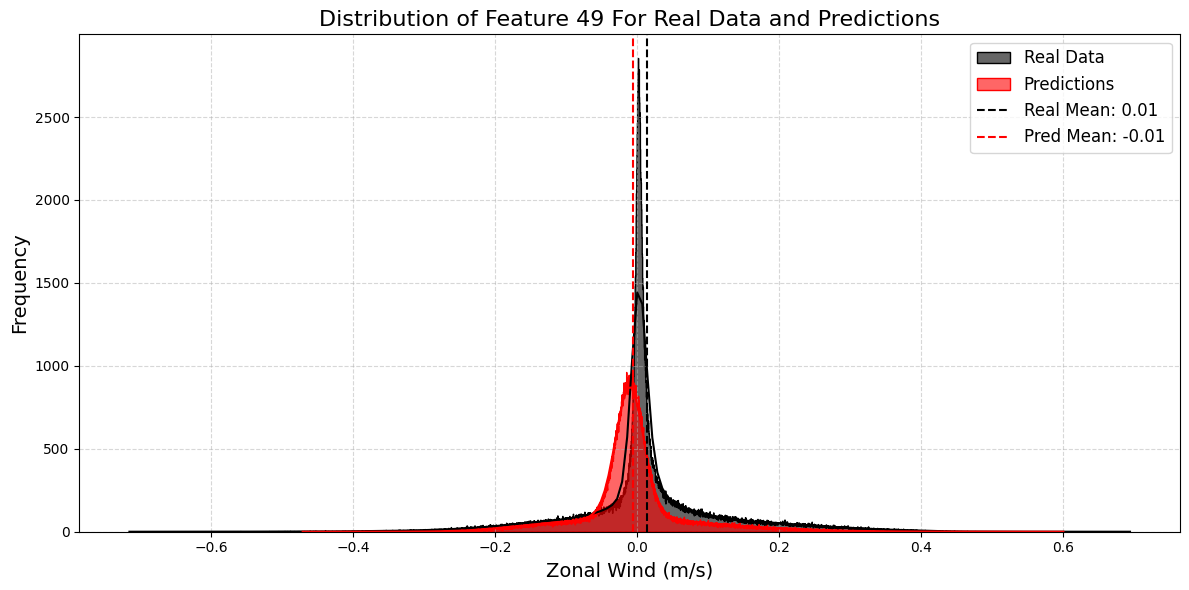

Row 24: TVD = 1514.404844
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


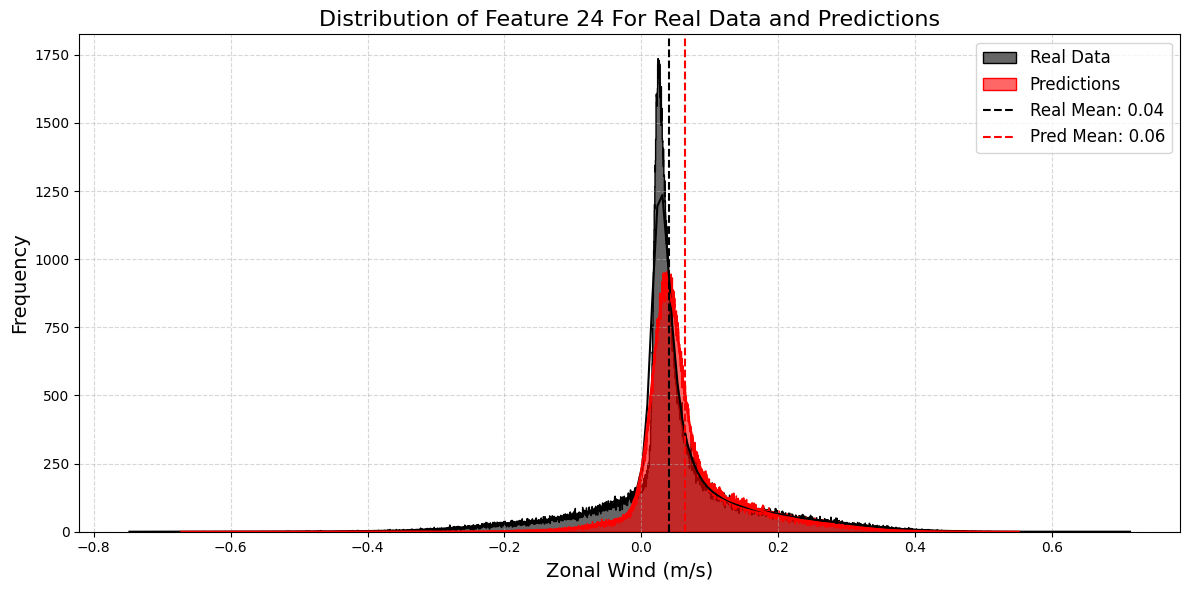

Row 48: TVD = 1067.863226
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


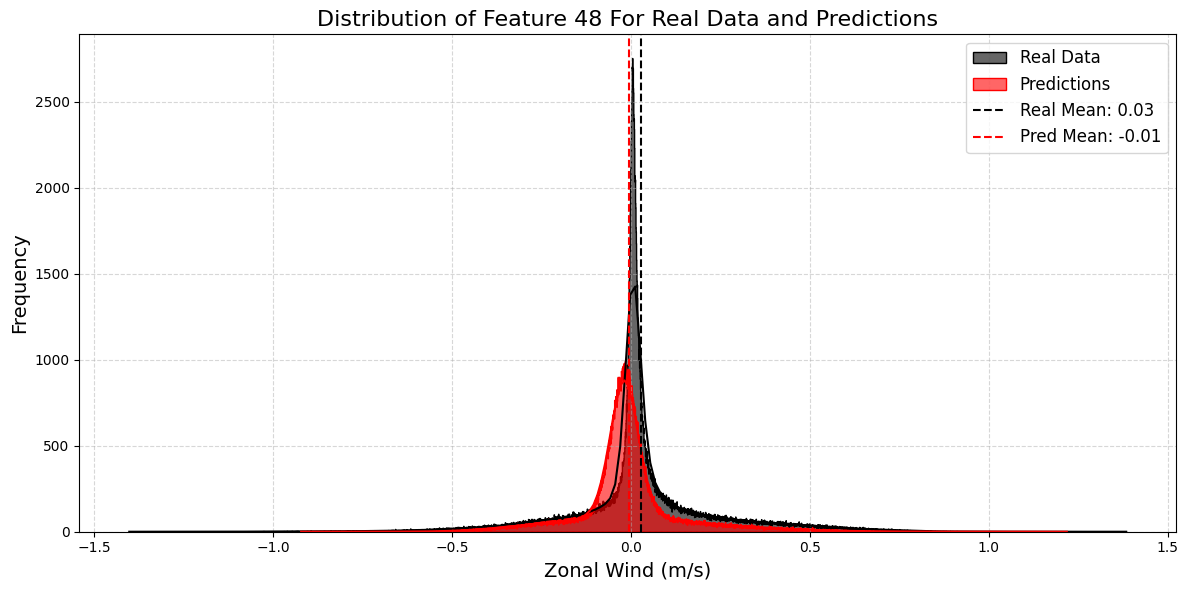

Row 23: TVD = 746.145015
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


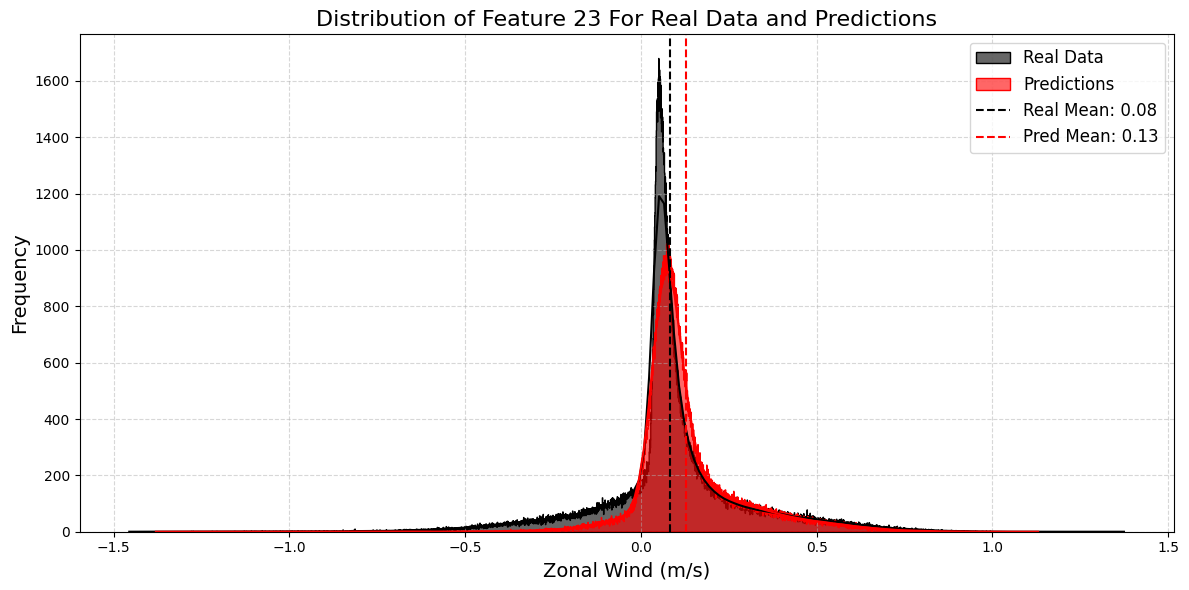

Row 47: TVD = 680.443602
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


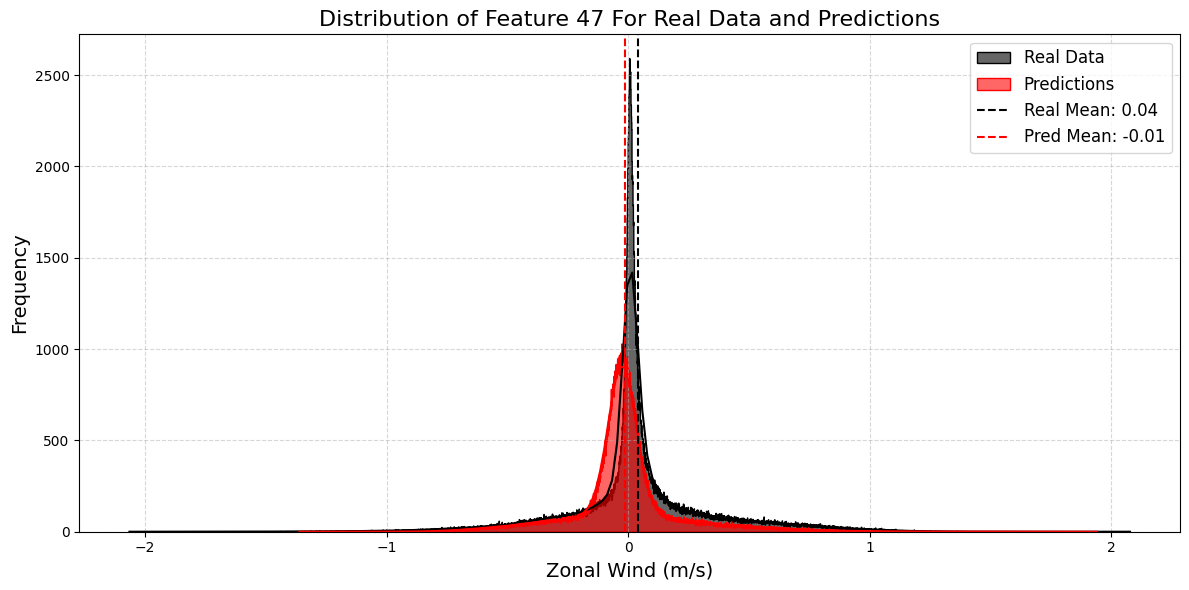

Row 50: TVD = 515.871588
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


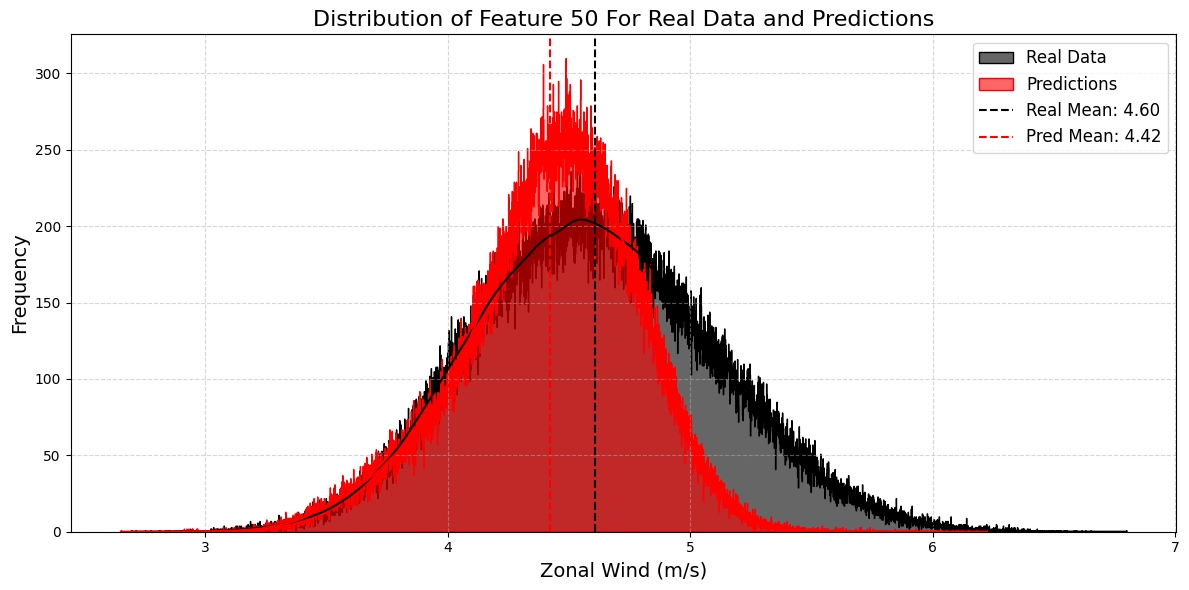

Row 46: TVD = 513.074901
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


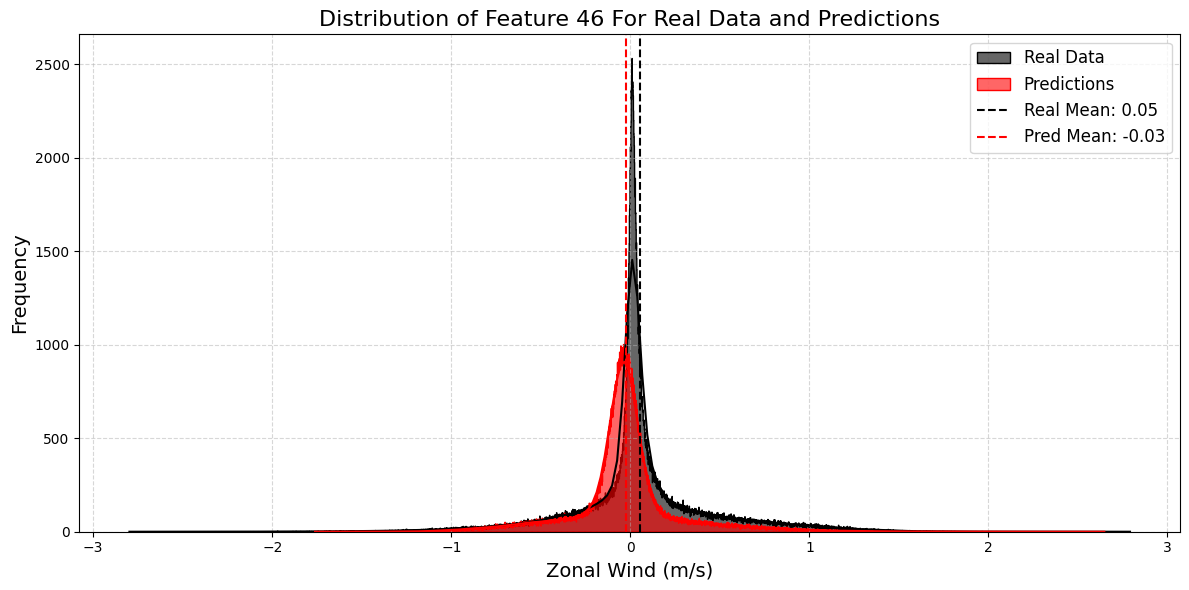

Row 22: TVD = 444.084878
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


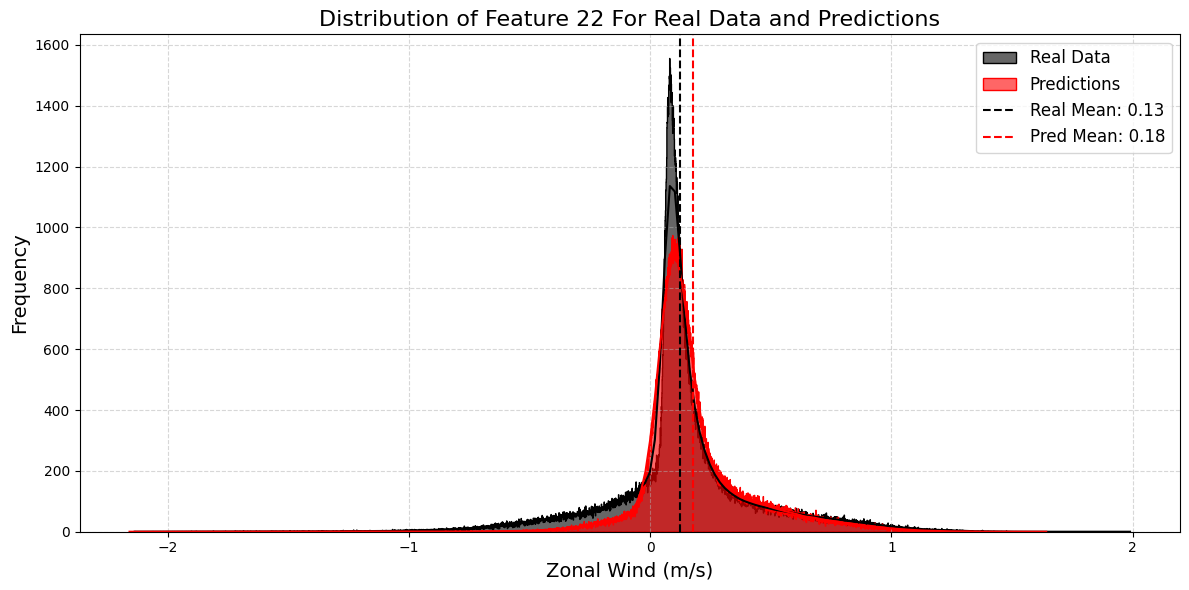

Row 21: TVD = 351.375733
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


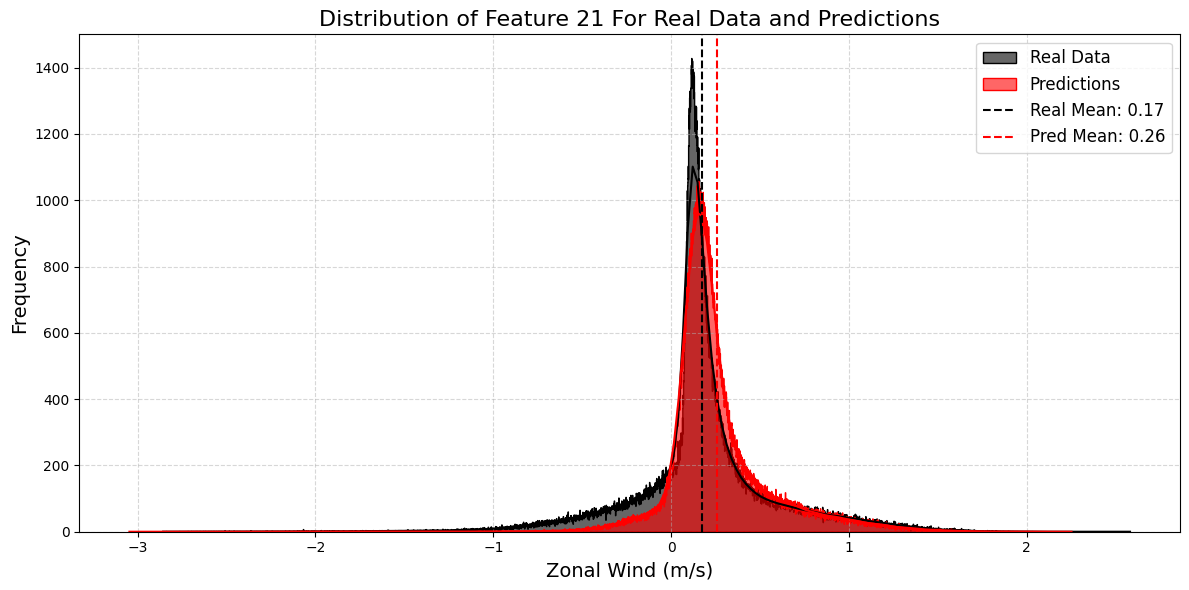

Row 45: TVD = 338.468269
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


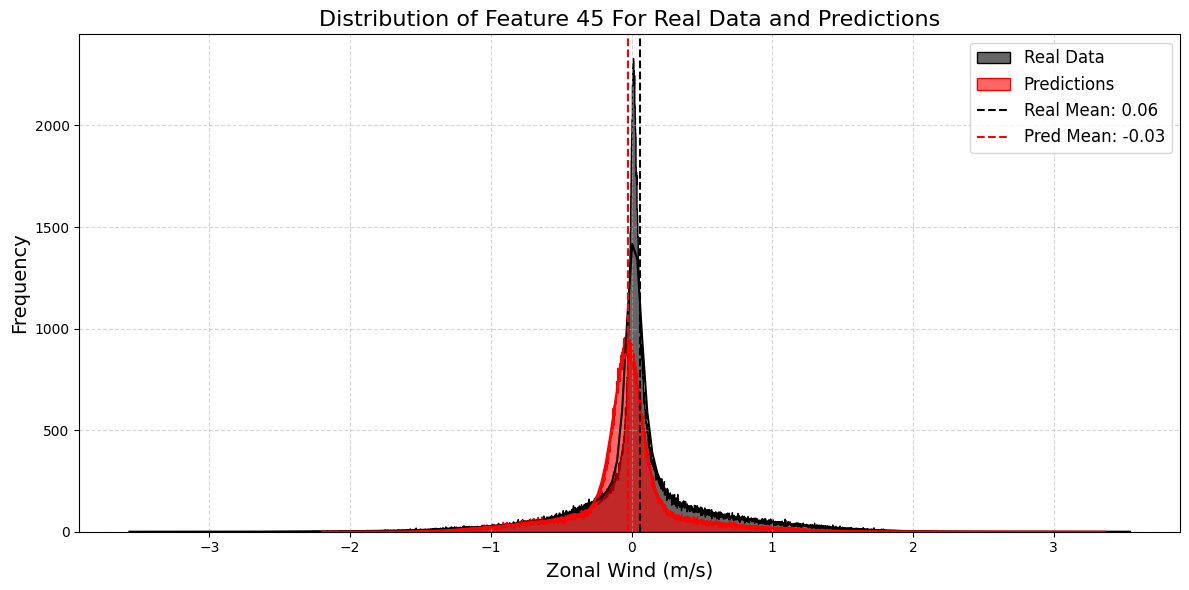

Row 20: TVD = 274.543377
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


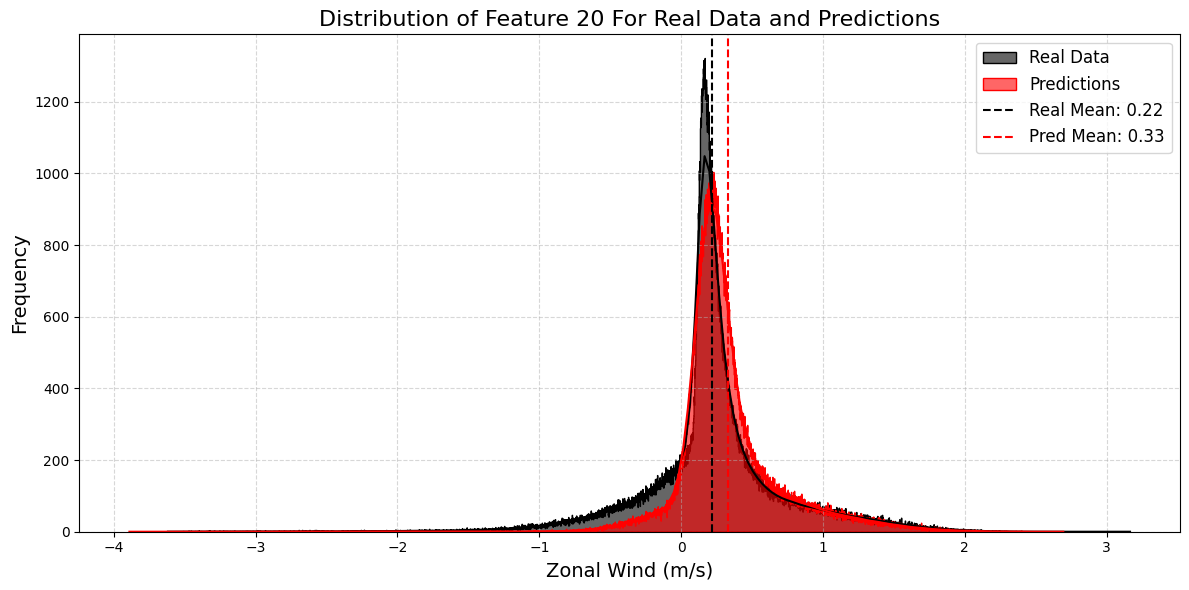

Row 44: TVD = 269.852216
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


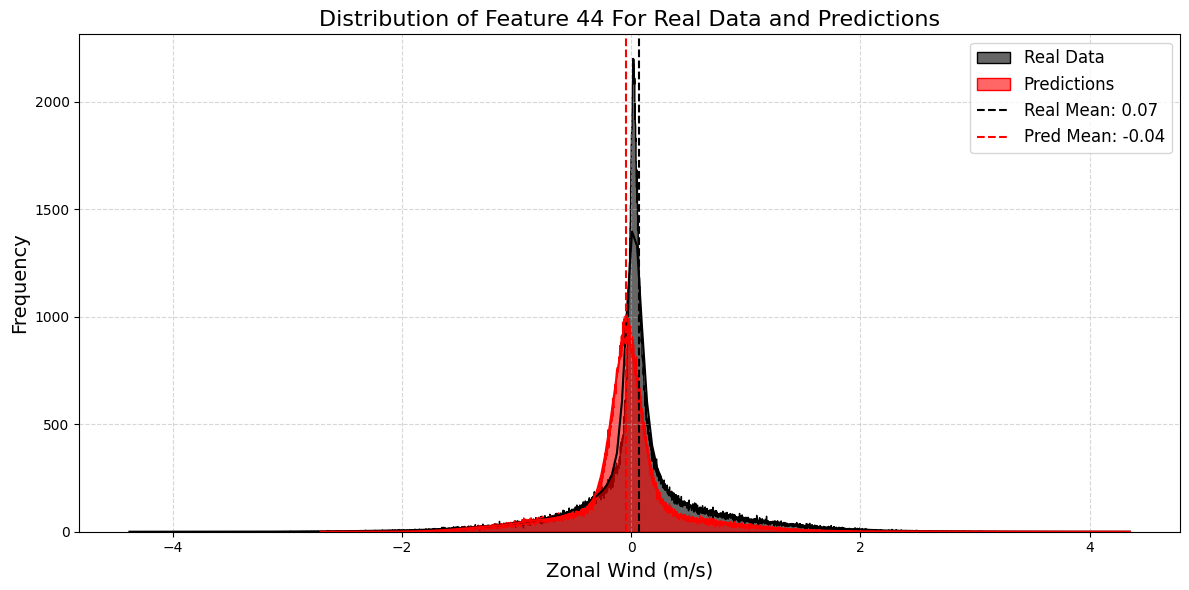

Row 51: TVD = 245.588945
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


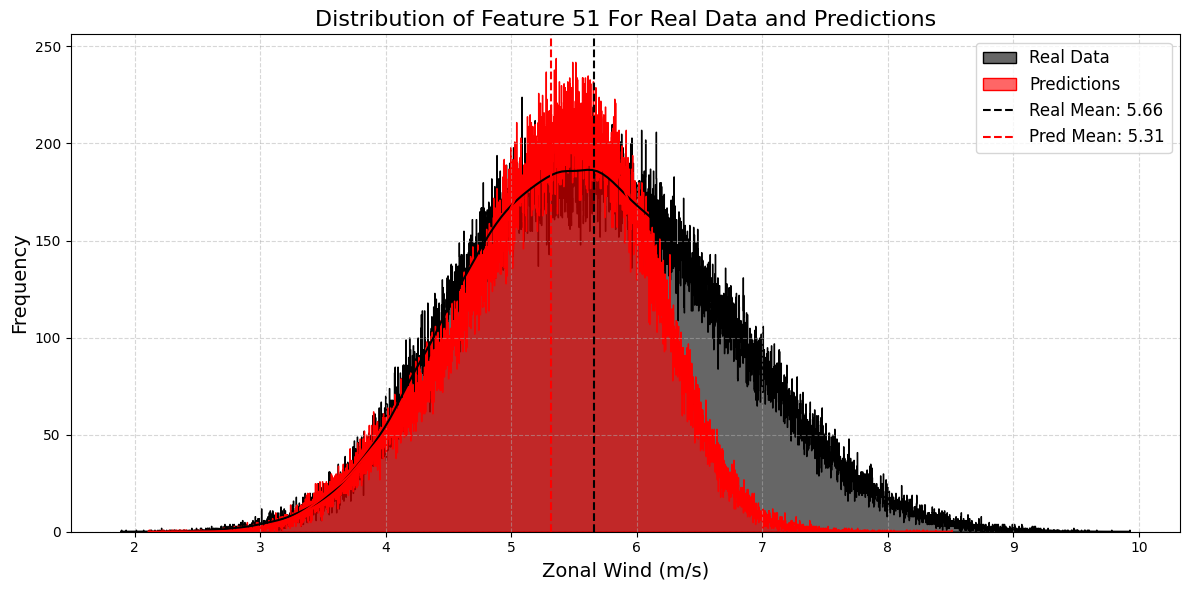

Row 19: TVD = 225.523940
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


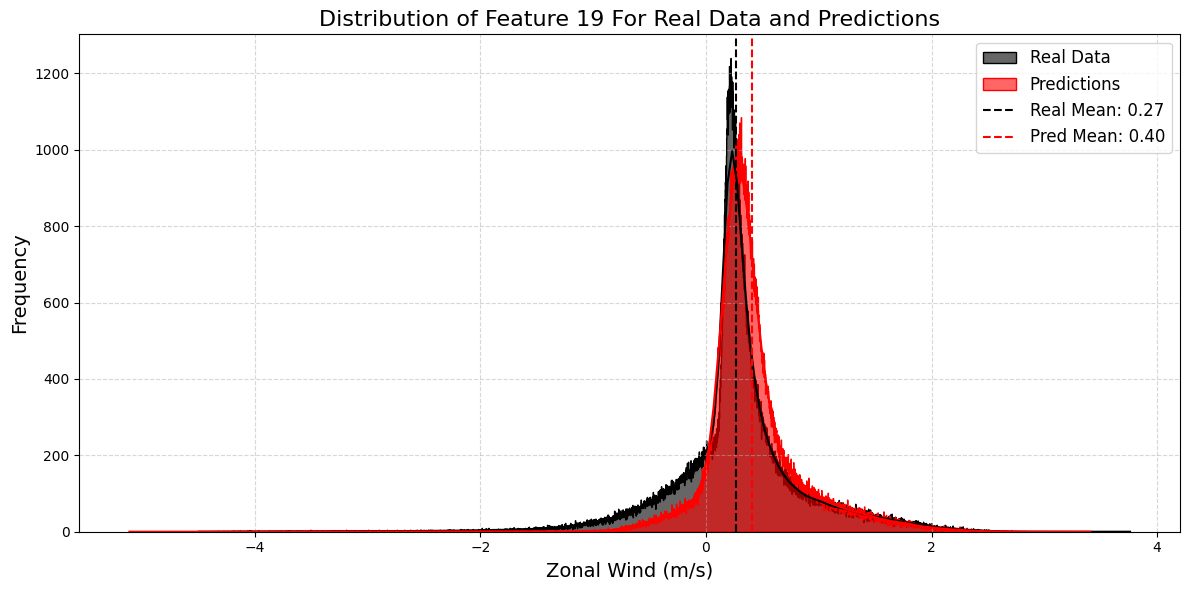

Row 43: TVD = 191.613988
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


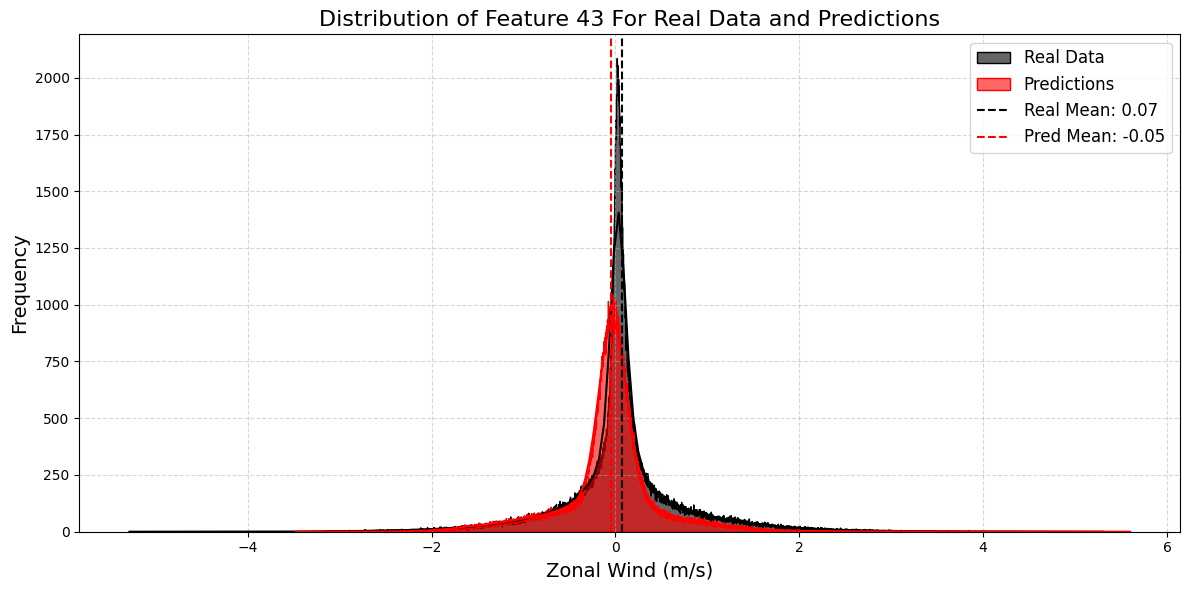

Row 18: TVD = 169.576082
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


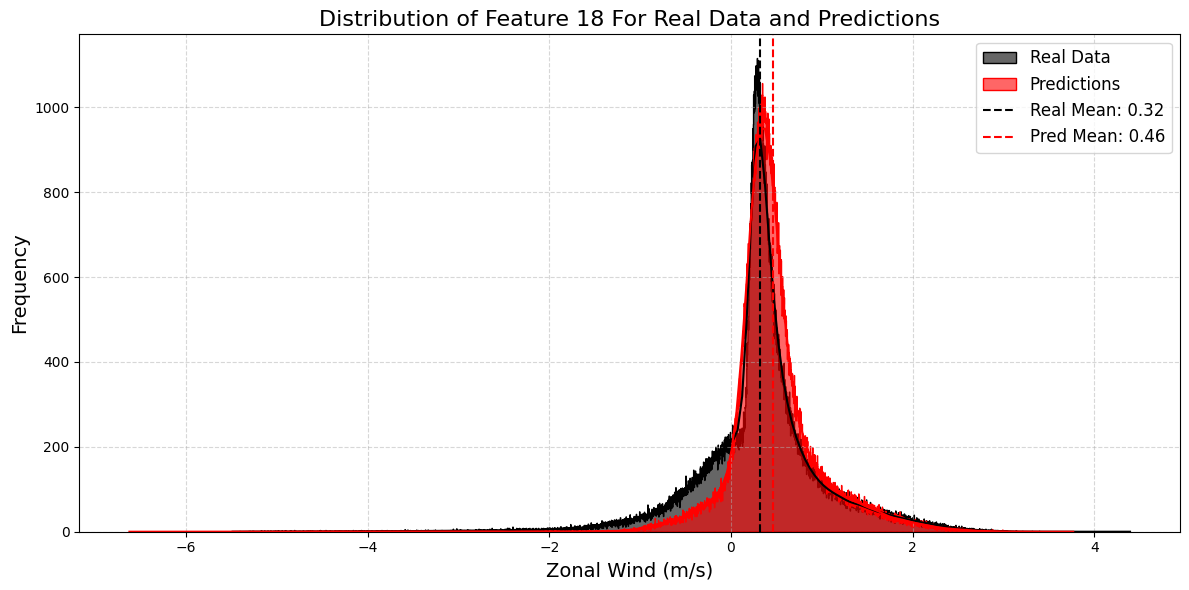

Row 52: TVD = 162.625265
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


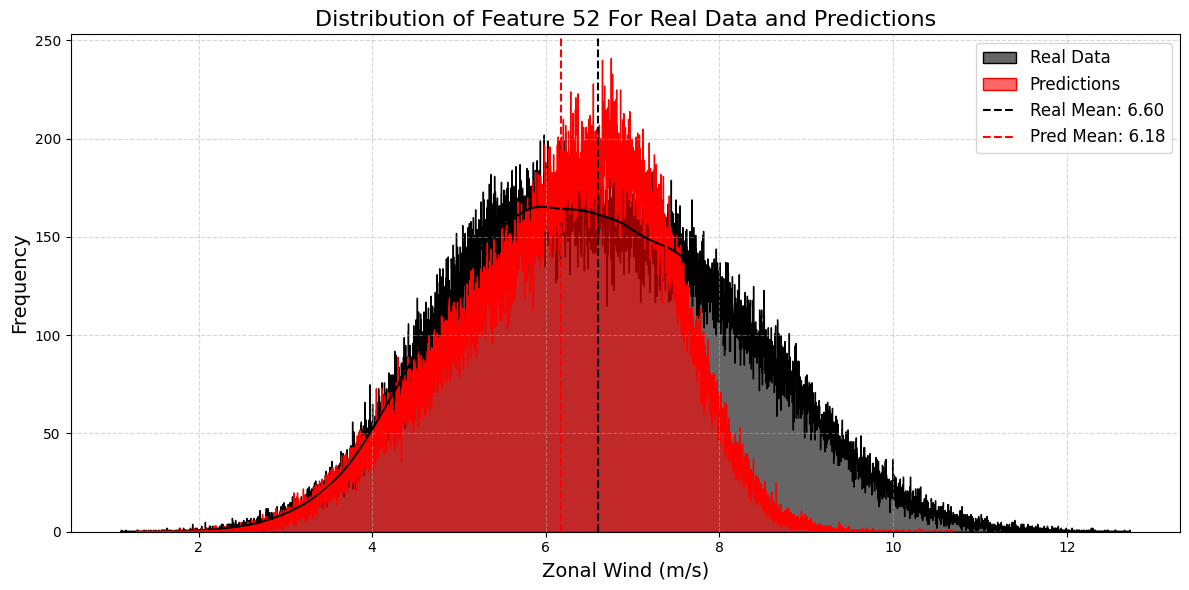

Row 42: TVD = 148.911844
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


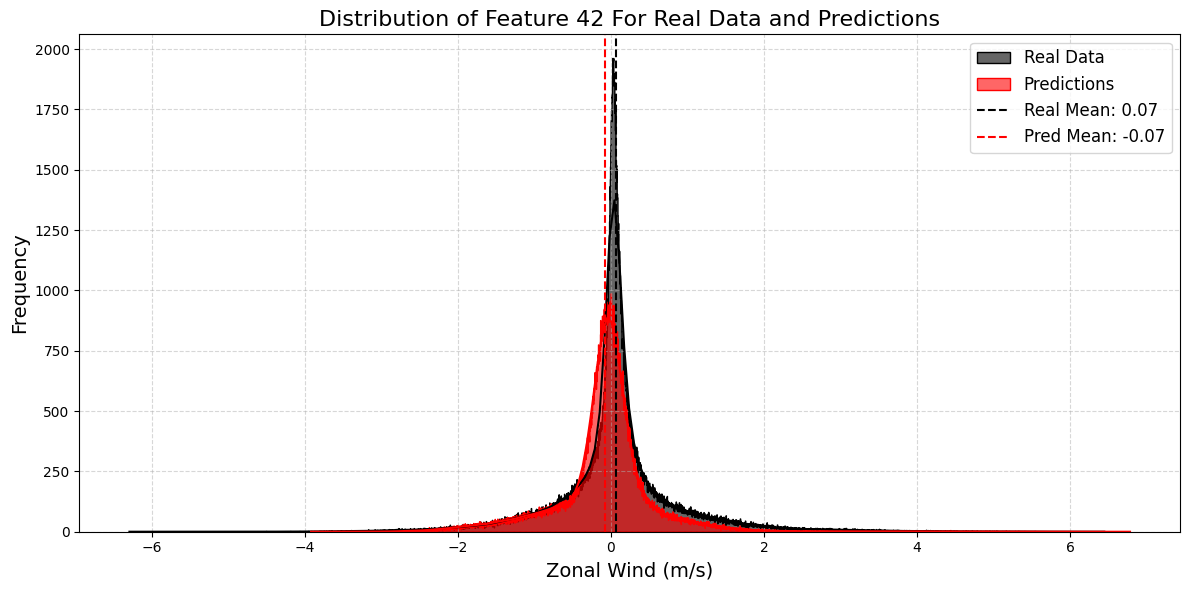

Row 17: TVD = 145.472898
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


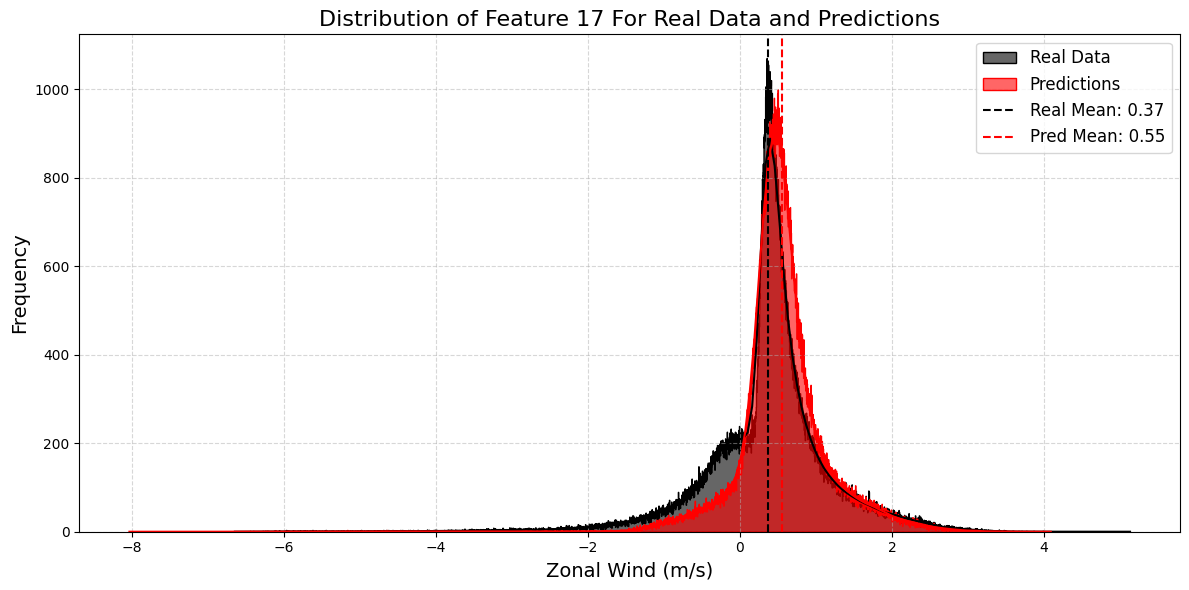

Row 53: TVD = 131.775148
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


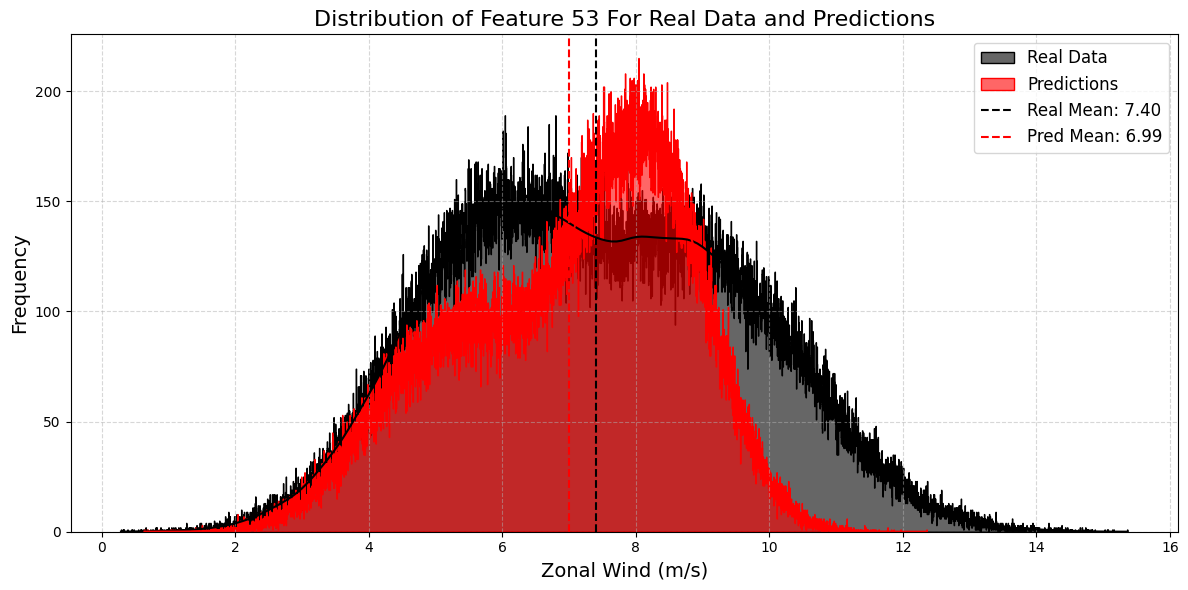

Row 54: TVD = 126.001066
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


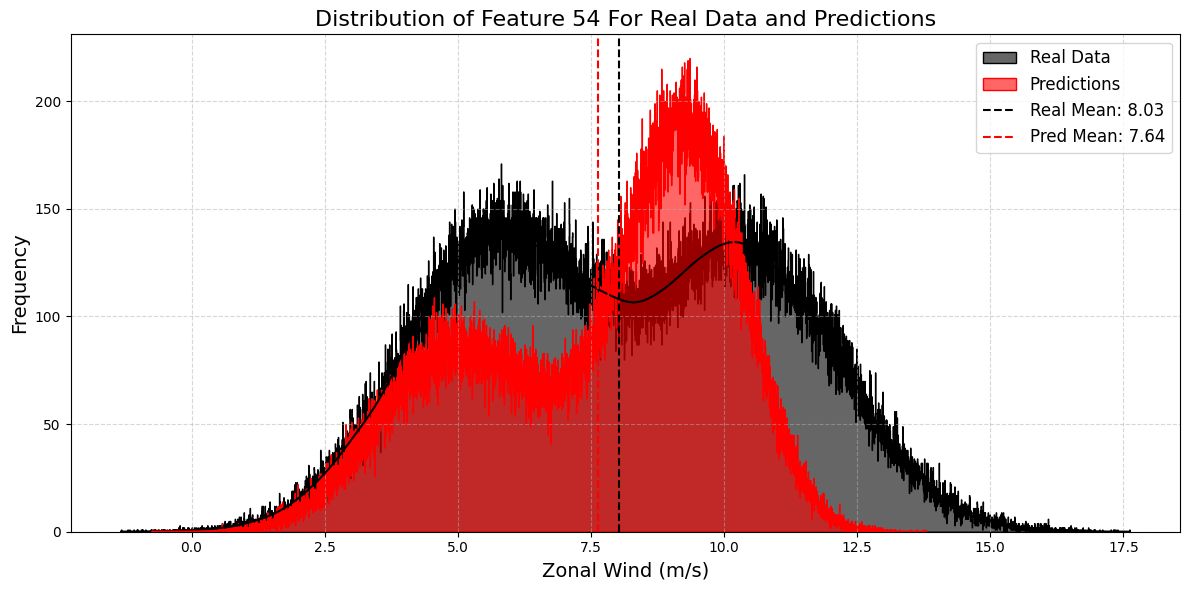

Row 16: TVD = 122.502424
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


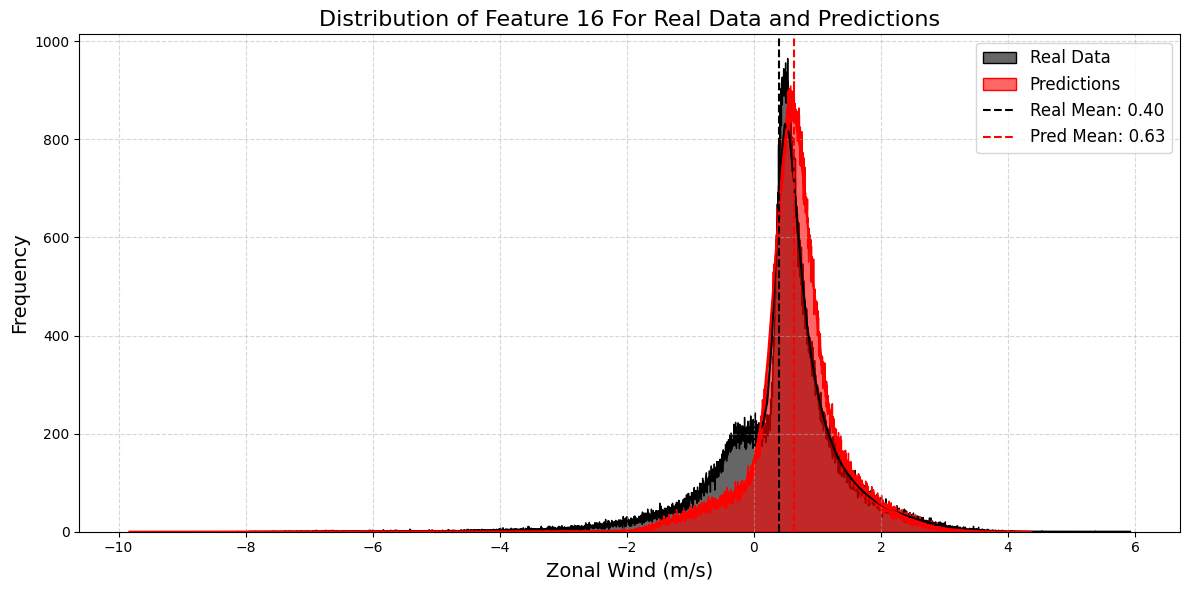

Row 55: TVD = 120.126211
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


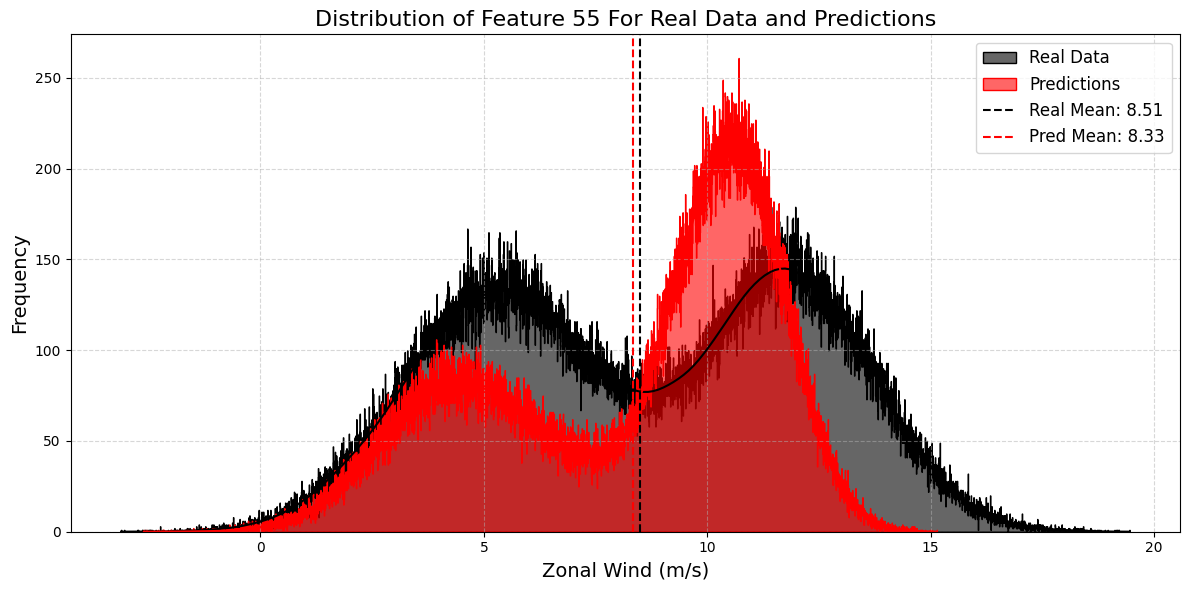

Row 56: TVD = 110.053825
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


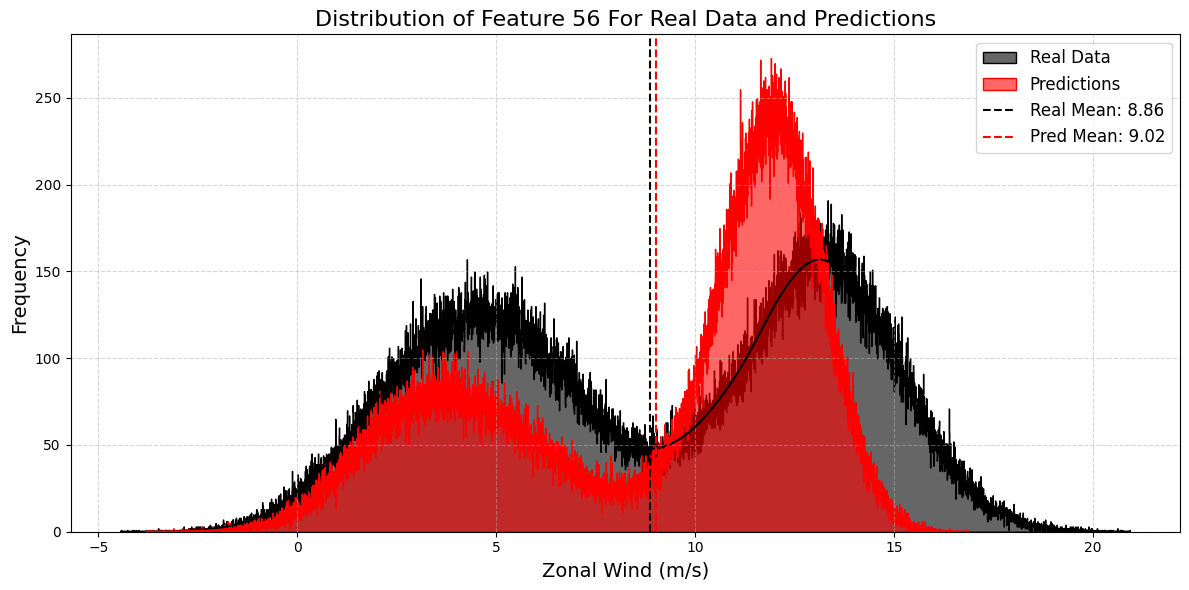

Row 41: TVD = 109.911042
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


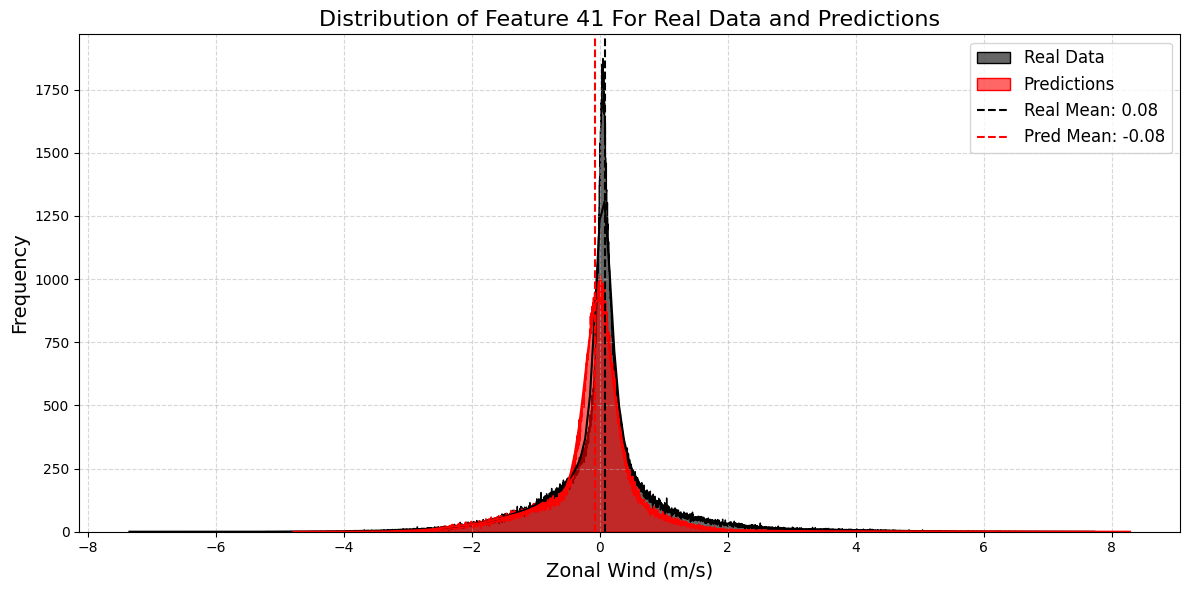

Row 15: TVD = 104.605589
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


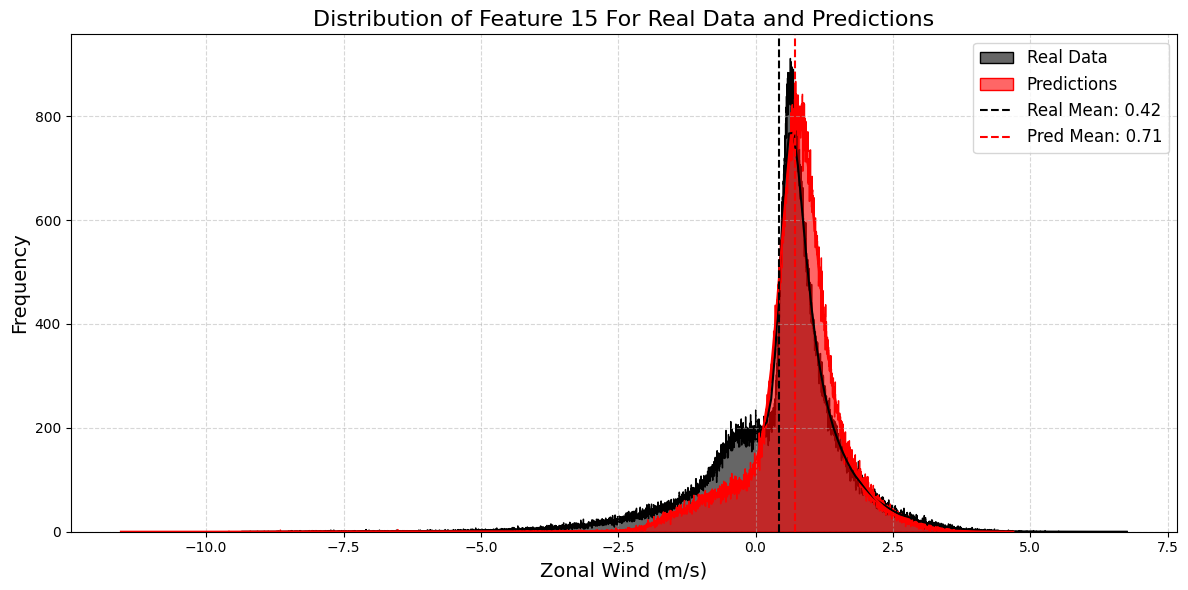

Row 14: TVD = 104.051129
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


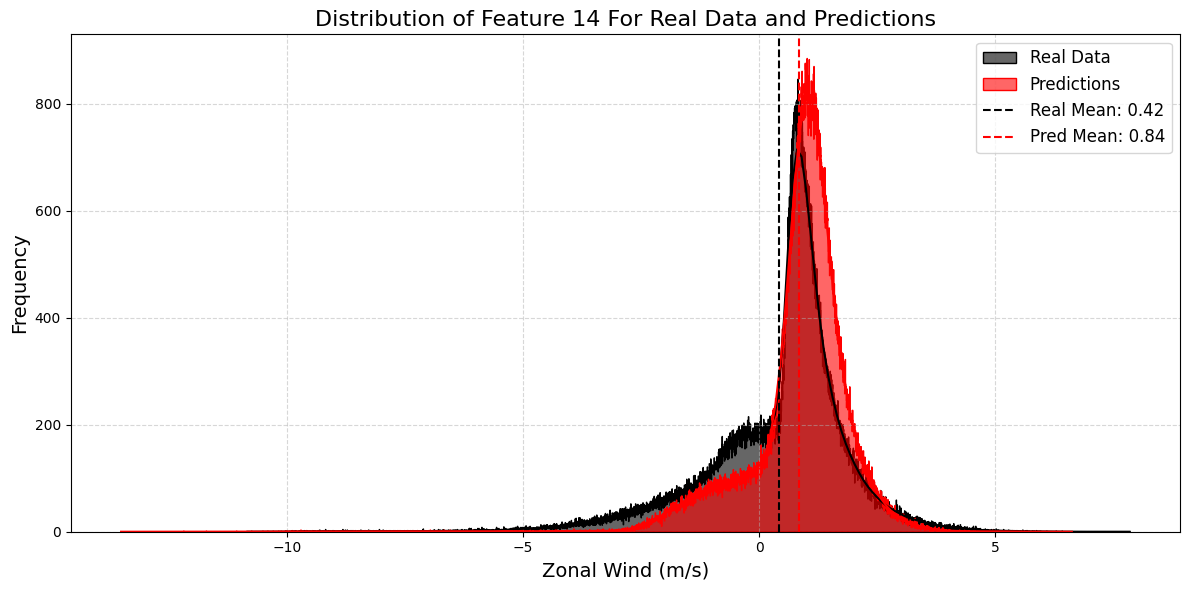

Row 57: TVD = 100.758572
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


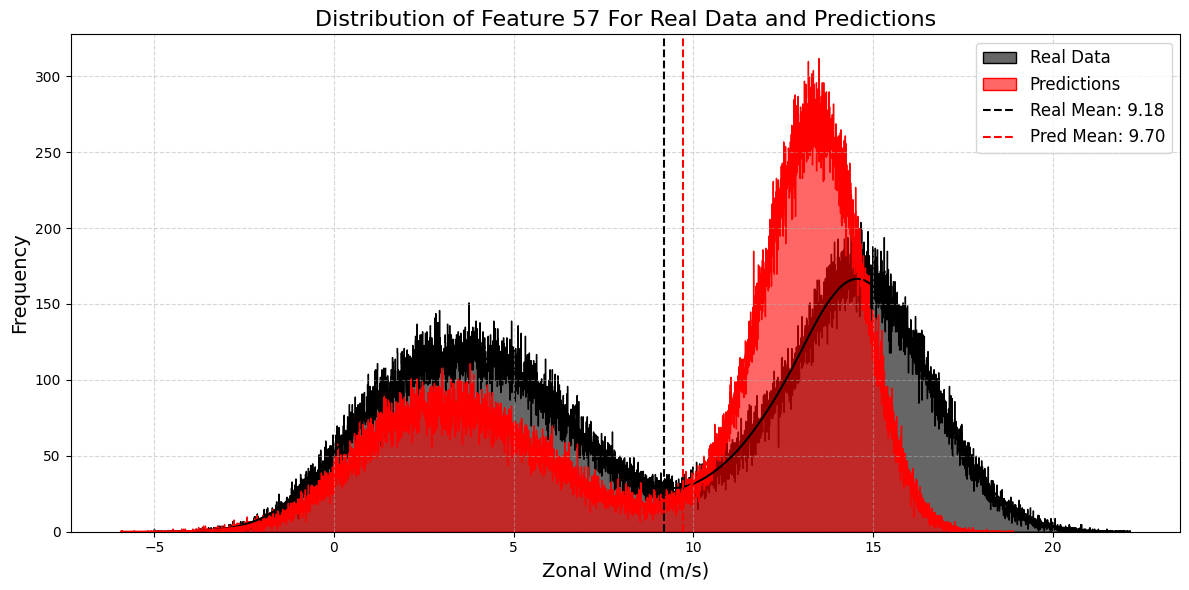

Row 0: TVD = 96.581192
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


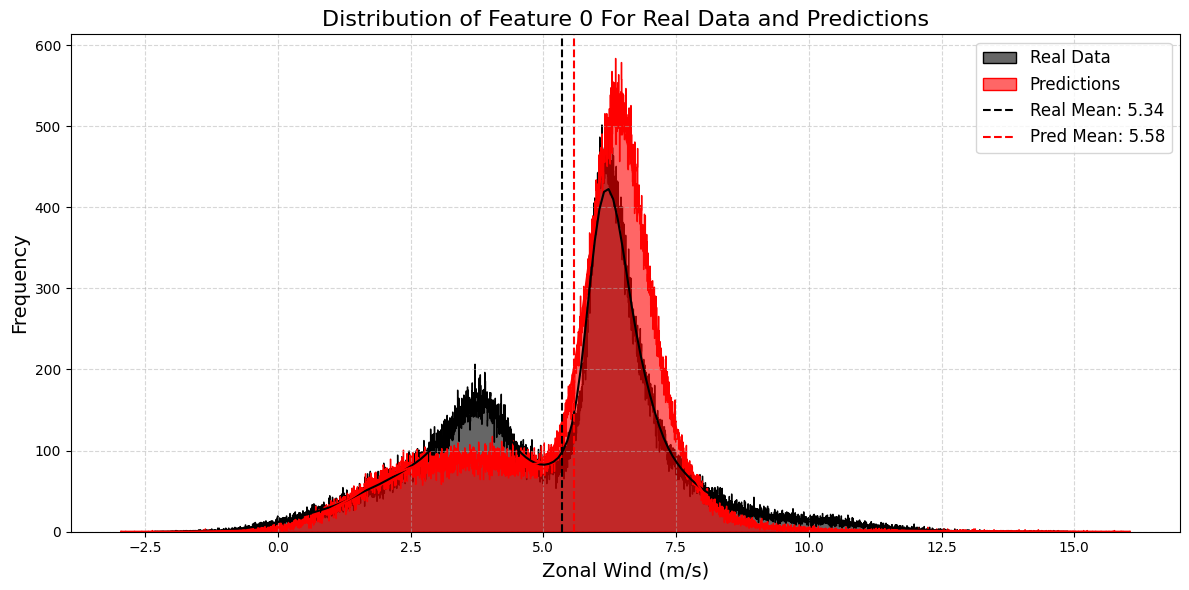

Row 25: TVD = 95.287131
Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


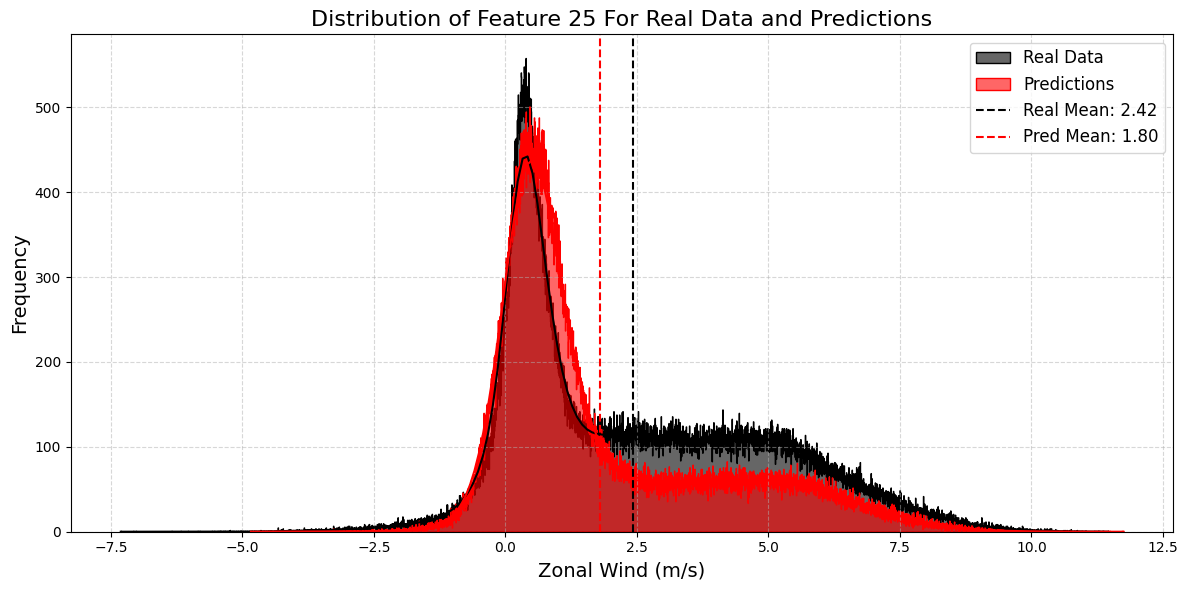

In [51]:
for i in range(0,30):
    print(f"Row {sorted_differences_in_ovl[i][1]}: TVD = {sorted_differences_in_ovl[i][0]:.6f}")
    data_real = real_data_1d[:, sorted_differences_in_ovl[i][1]]  # variable index 1 (e.g., zonal wind), level _
    data_predictions = predictions_1d[:, sorted_differences_in_ovl[i][1]]  # variable index 0 (predictions), level _

    print(f"Shape of zonal_wind_data_real: {data_real.shape}")
    print(f"Shape of zonal_wind_data_predictions: {data_predictions.shape}")

    # Plot the bimodal histogram
    plt.figure(figsize=(12, 6))

    # Create histograms (overlaid)
    sns.histplot(data_real, bins=5000, kde=True, color='black', alpha=0.6, element='step', label='Real Data')
    sns.histplot(data_predictions, bins=5000, kde=True, color='red', alpha=0.6, element='step', label='Predictions')

    # Customize plot labels and title
    plt.title(f"Distribution of Feature {sorted_differences_in_ovl[i][1]} For Real Data and Predictions", fontsize=16)
    plt.xlabel('Zonal Wind (m/s)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Add vertical lines at means
    plt.axvline(np.mean(data_real), color='black', linestyle='--', label=f'Real Mean: {np.mean(data_real):.2f}')
    plt.axvline(np.mean(data_predictions), color='red', linestyle='--', label=f'Pred Mean: {np.mean(data_predictions):.2f}')

    # Final plot settings
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(folder, "bi_modal_distribution")
    save_path = os.path.join(save_path, "bi_modal_distribution_plot")
    plt.savefig(save_path)
    plt.show()